In [1]:
import os
from astropy.io import fits
import numpy as np

# INPUT DIRECTORY (change this)
input_dir = "/Users/adeutsch/Desktop/UVA/25-fall/observational/final/pablo_data"


Star 4 outlier at exposure/frame 46: x = 133.96


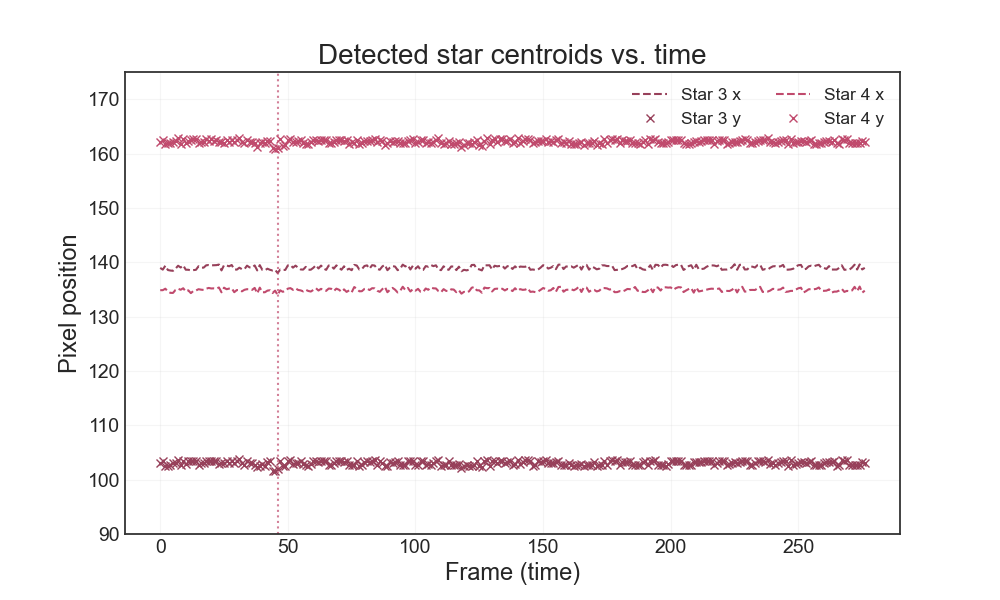

In [62]:
from scipy.spatial import cKDTree
from scipy.ndimage import label, center_of_mass
import os
import matplotlib.pyplot as plt

# Use your custom colormap
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list(
    "gray_pink", ["#222222", "#e75480", "#ffe4ec"]
)

star_positions = []
fits_files = sorted([f for f in os.listdir(input_dir) if f.lower().endswith((".fits"))])

# First, collect all centroids and uncertainties
star_positions = []
uncertainty_arrays = []
mjd_times = []
airmass = []

for fname in fits_files:
    fpath = os.path.join(input_dir, fname)
    with fits.open(fpath) as hdul:
        data = hdul[0].data.astype(float)
        data -= np.nanmedian(data)
        # JD Julian date from header
        jd = hdul[0].header.get('JD')
        mjd = jd - 2400000.5
        mjd_times.append(mjd)

        # get airmasses and store array
        am = hdul[0].header.get('AIRMASS')
        airmass.append(am)

        # Access uncertainty array from the second HDU (header/data unit)
        uncertainty = hdul[2].data.astype(float)
        uncertainty_arrays.append(uncertainty)
        threshold = np.std(data) * 5
        mask = data > threshold
        labeled, nstars = label(mask)
        centroids = center_of_mass(data, labeled, range(1, nstars+1))
        star_positions.append(centroids)

max_stars = max(len(frame) for frame in star_positions)
n_frames = len(star_positions)
x_positions = np.full((max_stars, n_frames), np.nan)
y_positions = np.full((max_stars, n_frames), np.nan)

# Use the first frame as reference
if star_positions[0]:
    ref = np.array(star_positions[0])
    y_positions[:len(ref), 0] = ref[:, 0]
    x_positions[:len(ref), 0] = ref[:, 1]
else:
    ref = np.full((max_stars, 2), np.nan)

for i in range(1, n_frames):
    curr = np.array(star_positions[i])
    if len(curr) == 0:
        continue

    # Only use finite reference points for matching
    finite_mask = np.isfinite(ref).all(axis=1)
    finite_ref_idx = np.where(finite_mask)[0]
    finite_ref = ref[finite_mask]

    if len(finite_ref) == 0:
        continue

    tree = cKDTree(curr)
    dists, idxs = tree.query(finite_ref, distance_upper_bound=10)

    # Fill in only for finite reference indices
    for k, j in enumerate(finite_ref_idx):
        dist = dists[k]
        idx = idxs[k]
        if idx < len(curr) and dist < 10:
            y_positions[j, i] = curr[idx][0]
            x_positions[j, i] = curr[idx][1]
        # else: leave as NaN

    # Safely update reference for next frame
    new_ref = []
    for j in range(max_stars):
        if not np.isnan(x_positions[j, i]) and not np.isnan(y_positions[j, i]):
            new_ref.append([y_positions[j, i], x_positions[j, i]])
        else:
            if j < len(ref):
                new_ref.append(ref[j])
            else:
                new_ref.append([np.nan, np.nan])
    ref = np.array(new_ref)

# Use custom_cmap for color selection
colors = [custom_cmap(i / max(1, max_stars - 1)) for i in range(max_stars)]

plt.figure(figsize=(10, 6))
for star in [3, 4]:
    plt.plot(range(n_frames), x_positions[star], linestyle='--', marker='', color=colors[star], label=f'Star {star} x')
    plt.plot(range(n_frames), y_positions[star], linestyle='None', marker='x', color=colors[star], label=f'Star {star} y')
    median_x = np.nanmedian(x_positions[star])
    std_x = np.nanstd(x_positions[star])
    for i in range(n_frames):
        x = x_positions[star, i]
        if not np.isnan(x) and abs(x - median_x) > 3 * std_x:
            plt.axvline(i, color=colors[star], linestyle=':', alpha=0.7)
            print(f"Star {star} outlier at exposure/frame {i}: x = {x:.2f}")

plt.xlabel("Frame (time)")
plt.ylabel("Pixel position")
plt.title("Detected star centroids vs. time")
plt.ylim(90, 175)
plt.legend(ncol=2, fontsize='small')
plt.show()

In [3]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
import numpy as np

# Observatory location (optional for barycentric, OK to include)
location = EarthLocation.of_site('Apache Point Observatory')


"""

coords: 
01 04 44.3624227608 
+74 19 52.857091056 

"""
# Target coordinates
target_coord = SkyCoord(
    ra='01h04m44.36s',
    dec='+74d19m52.86s',
    frame='icrs'
)

mjd_times = np.array(mjd_times)

# Create Time object in UTC
t_utc = Time(mjd_times, format='mjd', scale='utc', location=location)

# Convert to TDB MJD (no light travel correction)
mjd_tdb = t_utc.tdb.mjd

# Compute barycentric light-travel-time correction
ltt_bary = t_utc.light_travel_time(target_coord)

# Compute BJD(TDB) and express as MJD
bmjd_tdb = (t_utc.tdb + ltt_bary).mjd

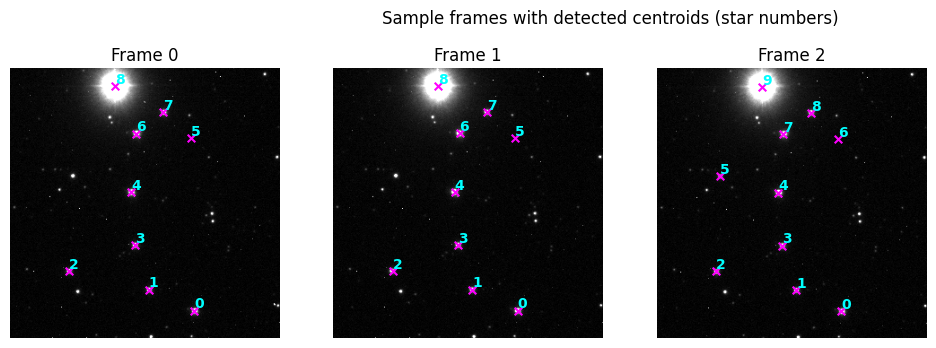

In [4]:
# Plot a few sample frames with detected centroids and label each star
sample_indices = (0, 1, 2)
plt.figure(figsize=(16, 4))
for j, idx in enumerate(sample_indices):
    fpath = os.path.join(input_dir, fits_files[idx])
    with fits.open(fpath) as hdul:
        data = hdul[0].data.astype(float)
        data -= np.nanmedian(data)
    centroids = star_positions[idx]
    plt.subplot(1, 4, j+1)
    plt.imshow(data, cmap='gray', origin='lower', vmin=np.percentile(data, 5), vmax=np.percentile(data, 99))
    if centroids:
        ys, xs = zip(*centroids)
        plt.scatter(xs, ys, color='magenta', s=30, marker='x')
        for k, (x, y) in enumerate(zip(xs, ys)):
            plt.text(x, y, str(k), color='cyan', fontsize=10, ha='left', va='bottom', weight='bold')
    plt.title(f"Frame {idx}")
    plt.axis('off')
plt.suptitle("Sample frames with detected centroids (star numbers)")
plt.show()

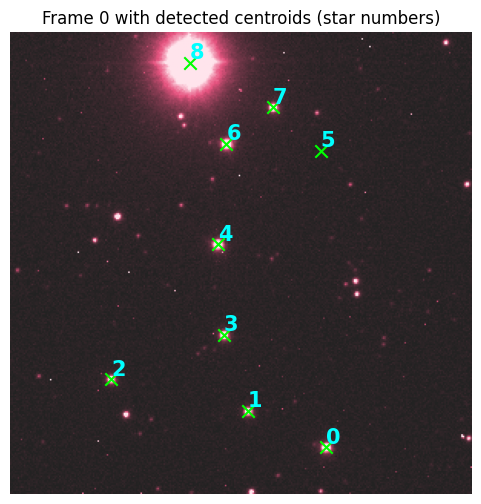

In [5]:
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap from dark gray to light pink
custom_cmap = LinearSegmentedColormap.from_list(
    "gray_pink", ["#222222", "#e75480", "#ffe4ec"]
)

# Plot a single frame with detected centroids and label each star
frame_idx = 0  # Change this to plot a different frame
plt.figure(figsize=(6, 6))
fpath = os.path.join(input_dir, fits_files[frame_idx])
with fits.open(fpath) as hdul:
    data = hdul[0].data.astype(float)
    data -= np.nanmedian(data)
centroids = star_positions[frame_idx]

plt.imshow(
    data,
    cmap=custom_cmap,
    origin='lower',
    vmin=np.percentile(data, 5),
    vmax=np.percentile(data, 99)
)

if centroids:
    ys, xs = zip(*centroids)
    plt.scatter(xs, ys, color='lime', s=80, marker='x')
    for k, (x, y) in enumerate(zip(xs, ys)):
        plt.text(x, y, str(k), color='cyan', fontsize=15, ha='left', va='bottom', weight='bold')
plt.title(f"Frame {frame_idx} with detected centroids (star numbers)")
plt.axis('off')
plt.show()

Frame 0 uncertainty: median = 4.395410363e+01, std = 8.487225903e+00


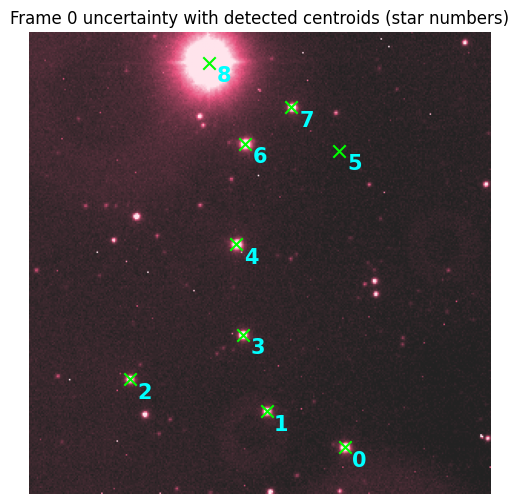

In [6]:
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap from dark gray to light pink
custom_cmap = LinearSegmentedColormap.from_list(
    "gray_pink", ["#222222", "#e75480", "#ffe4ec"]
)

# Plot a single frame with detected centroids on the uncertainty frame and label each star
frame_idx = 0  # Change this to plot a different frame
plt.figure(figsize=(6, 6))
fpath = os.path.join(input_dir, fits_files[frame_idx])
with fits.open(fpath) as hdul:
    uncertainty = hdul[2].data.astype(float)
centroids = star_positions[frame_idx]


# print median and std of uncertainty
median_uncertainty = np.nanmedian(uncertainty)
std_uncertainty = np.std(uncertainty)
print(f"Frame {frame_idx} uncertainty: median = {median_uncertainty:.9e}, std = {std_uncertainty:.9e}")
plt.imshow(
    uncertainty,
    cmap=custom_cmap,
    origin='lower',
    vmin=np.percentile(uncertainty, 5),
    vmax=np.percentile(uncertainty, 99)
)

if centroids:
    ys, xs = zip(*centroids)
    plt.scatter(xs, ys, color='lime', s=80, marker='x')
    for k, (x, y) in enumerate(zip(xs, ys)):
        plt.text(x+5, y-15, str(k), color='cyan', fontsize=15, ha='left', va='bottom', weight='bold')
plt.title(f"Frame {frame_idx} uncertainty with detected centroids (star numbers)")
plt.axis('off')
plt.show()

In [7]:
target_star = 4
comp_stars = [1,3,7]
# [0,1,2,3,4,5,6,7,8]  # indices of comparison stars

aperture_radius = 2.4 # * fwhm
annulus_r_in = 4 # * fwhm
annulus_r_out = 6 # * fwhm


aperture_radius_fwhm = aperture_radius # * fwhm
annulus_r_in_fwhm = annulus_r_in # * fwhm
annulus_r_out_fwhm = annulus_r_out # * fwhm

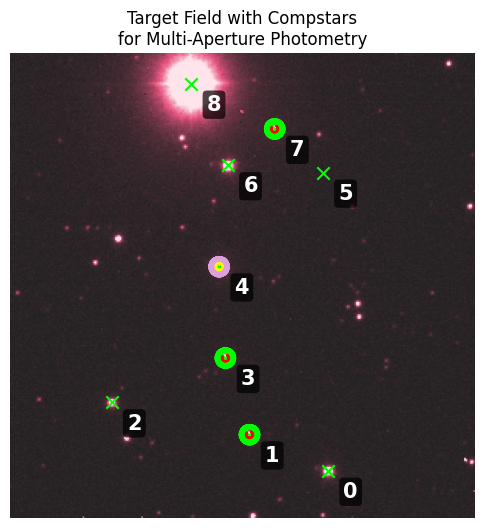

In [8]:
# first, use sigma clipping to mask any hot pixels where the brightness of any pixel is more than 5 sigma above the median of its neighboring pixels:
from scipy.ndimage import median_filter
from matplotlib.patches import Circle


def mask_hot_pixels(data, sigma=7):
    # Only mask a pixel if it is much brighter than ALL its 4-connected neighbors (not a star core)
    from scipy.ndimage import generic_filter

    def is_hot_pixel(values):
        center = values[4]
        neighbors = np.delete(values, 4)
        median_neighbors = np.nanmedian(neighbors)
        std_neighbors = np.std(neighbors)
        return (center - median_neighbors) > (sigma * std_neighbors) and np.all(center > neighbors + sigma * std_neighbors)

    mask = generic_filter(data, is_hot_pixel, size=3, mode='reflect').astype(bool)
    data_masked = data.copy()
    data_masked[mask] = np.nanmedian(data)  # or use median of neighbors if you prefer
    return data_masked
    

# --- Draw apertures and annuli on a single frame ---
frame_idx = 0  # Change this to plot a different frame
plt.figure(figsize=(6, 8))
fpath = os.path.join(input_dir, fits_files[frame_idx])
with fits.open(fpath) as hdul:
    data = hdul[0].data.astype(float)
    data -= np.nanmedian(data)
    data = mask_hot_pixels(data, sigma=7)  # Apply hot pixel masking
centroids = star_positions[frame_idx]

plt.imshow(
    data,
    cmap=custom_cmap,
    origin='lower',
    vmin=np.percentile(data, 5),
    vmax=np.percentile(data, 99)
)

shift_y = 40  # vertical shift for comp stars

if centroids:
    ys, xs = zip(*centroids)
    plt.scatter(xs, ys, color='lime', s=80, marker='x')
for k, (x, y) in enumerate(zip(xs, ys)):
    plt.text(
        x+10, y-20, str(k),
        color='white',
        fontsize=15,
        ha='left',
        va='bottom',
        weight='bold',
        bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
    )
    # Draw aperture and annulus for target star
    if target_star < len(xs):
        circ = Circle((xs[target_star], ys[target_star]), aperture_radius, edgecolor='yellow', facecolor='none', lw=2)
        plt.gca().add_patch(circ)
        annulus = Circle((xs[target_star], ys[target_star]), annulus_r_out, edgecolor='plum', facecolor='none', lw=2, linestyle='-')
        plt.gca().add_patch(annulus)
        annulus_inner = Circle((xs[target_star], ys[target_star]), annulus_r_in, edgecolor='plum', facecolor='none', lw=2, linestyle='-')
        plt.gca().add_patch(annulus_inner)
        # --- Add aperture label in bottom left with arrow pointing in ---
        # plt.annotate(
        #     "Aperture",
        #     xy=(xs[target_star] - aperture_radius * 0.7, ys[target_star] - aperture_radius * 0.7),
        #     xytext=(xs[target_star] - annulus_r_out * 1.2, ys[target_star] - annulus_r_out * 1.2),
        #     color='yellow',
        #     fontsize=15,
        #     fontweight='bold',
        #     arrowprops=dict(arrowstyle="->", color='yellow', lw=2, shrinkA=0, shrinkB=5),
        #     bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2')
        # )
        # # --- Add background annulus label in top right with arrow pointing in ---
        # plt.annotate(
        #     "Background Annulus",
        #     xy=(xs[target_star] + (annulus_r_in + annulus_r_out)/2, ys[target_star] + (annulus_r_in + annulus_r_out)/2),
        #     xytext=(xs[target_star] + annulus_r_out * 1.2, ys[target_star] + annulus_r_out * 1.2),
        #     color='lime',
        #     fontsize=15,
        #     fontweight='bold',
        #     arrowprops=dict(arrowstyle="->", color='lime', lw=2, shrinkA=0, shrinkB=5),
        #     bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2')
        # )
    # Draw apertures and annuli for comparison stars (NO shift)
    for comp in comp_stars:
        if comp < len(xs):
            circ = Circle((xs[comp], ys[comp]), aperture_radius, edgecolor='red', facecolor='none', lw=2, linestyle='--')
            plt.gca().add_patch(circ)
            annulus = Circle((xs[comp], ys[comp]), annulus_r_out, edgecolor='lime', facecolor='none', lw=2, linestyle='-')
            plt.gca().add_patch(annulus)
            annulus_inner = Circle((xs[comp], ys[comp]), annulus_r_in, edgecolor='lime', facecolor='none', lw=2, linestyle='-')
            plt.gca().add_patch(annulus_inner)
            # Label comp stars
            # plt.text(xs[comp], ys[comp], f"{comp}", color='magenta', fontsize=15, ha='left', va='bottom', weight='bold')
plt.title(f"Target Field with Compstars\nfor Multi-Aperture Photometry")
plt.axis('off')
plt.show()

In [9]:
# --- Utility: Mask hot pixels in data array ---
def mask_hot_pixels(data, sigma=10):
    from scipy.ndimage import generic_filter
    def is_hot_pixel(values):
        center = values[4]
        neighbors = np.delete(values, 4)
        median_neighbors = np.nanmedian(neighbors)
        std_neighbors = np.std(neighbors)
        return (center - median_neighbors) > (sigma * std_neighbors) and np.all(center > neighbors + sigma * std_neighbors)
    mask = generic_filter(data, is_hot_pixel, size=3, mode='reflect').astype(bool)
    data_masked = data.copy()
    data_masked[mask] = np.nan  # Set hot pixels to NaN so they are ignored in photometry
    return data_masked


Text(0.5, 1.0, 'Target Star FWHM vs. time')

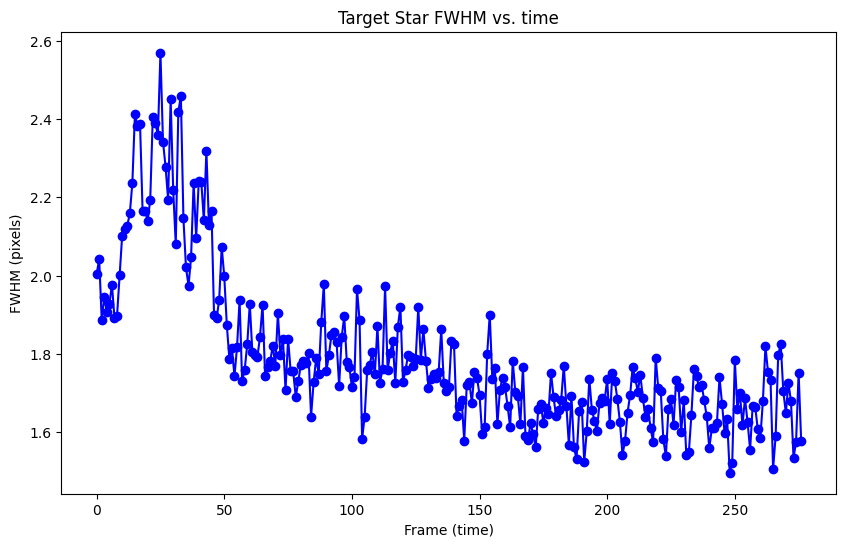

In [11]:
from photutils.psf import IntegratedGaussianPRF
from astropy.modeling import models, fitting

fwhm_target = []
for i in range(n_frames):
    if target_star >= max_stars or np.isnan(x_positions[target_star, i]) or np.isnan(y_positions[target_star, i]):
        fwhm_target.append(np.nan)
        continue
    fpath = os.path.join(input_dir, fits_files[i])
    with fits.open(fpath) as hdul:
        data = hdul[0].data.astype(float)
        data -= np.nanmedian(data)
    y0, x0 = y_positions[target_star, i], x_positions[target_star, i]
    size = 9  # pixels (should be odd)
    x1, x2 = int(x0) - size//2, int(x0) + size//2 + 1
    y1, y2 = int(y0) - size//2, int(y0) + size//2 + 1
    if x1 < 0 or y1 < 0 or x2 > data.shape[1] or y2 > data.shape[0]:
        fwhm_target.append(np.nan)
        continue
    cutout = data[y1:y2, x1:x2]
    y_grid, x_grid = np.mgrid[0:cutout.shape[0], 0:cutout.shape[1]]
    p_init = models.Gaussian2D(amplitude=cutout.max(), x_mean=size//2, y_mean=size//2, x_stddev=2, y_stddev=2)
    fit_p = fitting.LevMarLSQFitter()
    try:
        p = fit_p(p_init, x_grid, y_grid, cutout)
        fwhm = 2.3548 * np.nanmean([p.x_stddev.value, p.y_stddev.value])
        fwhm_target.append(fwhm)
    except Exception:
        fwhm_target.append(np.nan)

#plot fwhm vs time
plt.figure(figsize=(10, 6))
plt.plot(range(n_frames), fwhm_target, linestyle='-', marker='o', color='blue', label='Target Star FWHM')
plt.xlabel("Frame (time)")
plt.ylabel("FWHM (pixels)")
plt.title("Target Star FWHM vs. time")

In [12]:
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

target_brightness = []
target_uncertainty = []
comp_brightness = [[] for _ in comp_stars]
comp_uncertainty = [[] for _ in comp_stars]

for i in range(n_frames):
    if i % 50 == 0:
        print(f"Processing frame {i+1}/{n_frames}...")

    fwhm_this = fwhm_target[i] if not np.isnan(fwhm_target[i]) else 2.0
    aperture_radius = aperture_radius_fwhm * fwhm_this
    annulus_r_in = annulus_r_in_fwhm * fwhm_this
    annulus_r_out = annulus_r_out_fwhm * fwhm_this

    fpath = os.path.join(input_dir, fits_files[i])
    with fits.open(fpath) as hdul:
        data = hdul[0].data.astype(float)
        data -= np.nanmedian(data)
        uncertainty = hdul[2].data.astype(float)

    # Gather all valid positions (target + comps)
    star_indices = [target_star] + comp_stars
    positions = []
    valid_indices = []
    for idx, star in enumerate(star_indices):
        if star < max_stars and not np.isnan(x_positions[star, i]) and not np.isnan(y_positions[star, i]):
            positions.append((x_positions[star, i], y_positions[star, i]))
            valid_indices.append(idx)
        else:
            if idx == 0:
                target_brightness.append(np.nan)
                target_uncertainty.append(np.nan)
            else:
                comp_brightness[idx-1].append(np.nan)
                comp_uncertainty[idx-1].append(np.nan)

    if not positions:
        continue

    aperture = CircularAperture(positions, r=aperture_radius)
    annulus = CircularAnnulus(positions, r_in=annulus_r_in, r_out=annulus_r_out)
    phot_table = aperture_photometry(data, [aperture, annulus])

    for k, idx in enumerate(valid_indices):
        ap_sum = phot_table['aperture_sum_0'][k]
        an_sum = phot_table['aperture_sum_1'][k]
        bkg_mean = an_sum / annulus.area
        flux = ap_sum - bkg_mean * aperture.area

        # Uncertainty calculation (optional, can be skipped for speed)
        ap_mask = aperture.to_mask(method='center')[k]
        an_mask = annulus.to_mask(method='center')[k]
        ap_unc = ap_mask.multiply(uncertainty)
        an_unc = an_mask.multiply(uncertainty)
        ap_mask_bool = ap_mask.data.astype(bool)
        an_mask_bool = an_mask.data.astype(bool)
        ap_unc_sum = np.sqrt(np.nansum((ap_unc[ap_mask_bool])**2))
        an_unc_sum = np.sqrt(np.nansum((an_unc[an_mask_bool])**2))
        n_ap = np.sum(ap_mask_bool)
        n_an = np.sum(an_mask_bool)
        bkg_mean_unc = an_unc_sum / n_an if n_an > 0 else 0
        bkg_in_ap_unc = bkg_mean_unc * n_ap
        total_unc = np.sqrt(ap_unc_sum**2 + bkg_in_ap_unc**2)

        if idx == 0:
            target_brightness.append(flux)
            target_uncertainty.append(total_unc)
        else:
            comp_brightness[idx-1].append(flux)
            comp_uncertainty[idx-1].append(total_unc)

Processing frame 1/277...
Processing frame 51/277...
Processing frame 101/277...
Processing frame 151/277...
Processing frame 201/277...
Processing frame 251/277...


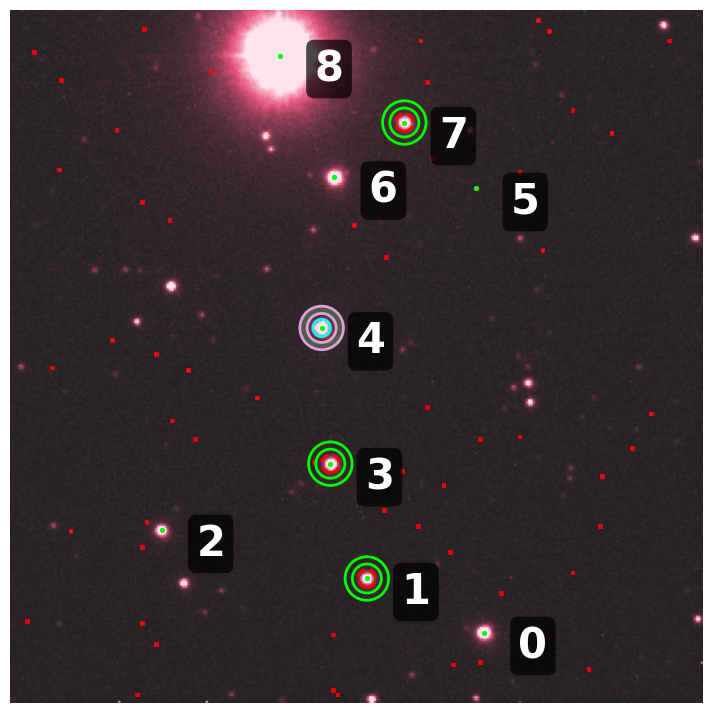

In [15]:
# --- Draw apertures and annuli on a single frame, FULL FIELD with all comp stars and target ---
from scipy.ndimage import median_filter
from matplotlib.patches import Circle, Wedge

def get_hot_pixel_mask(data, sigma=3):
    from scipy.ndimage import generic_filter
    def is_hot_pixel(values):
        center = values[4]
        neighbors = np.delete(values, 4)
        median_neighbors = np.nanmedian(neighbors)
        std_neighbors = np.std(neighbors)
        return (center - median_neighbors) > (sigma * std_neighbors) and np.all(center > neighbors + sigma * std_neighbors)
    mask = generic_filter(data, is_hot_pixel, size=3, mode='reflect')
    return mask.astype(bool)

frame_idx = 1  # Change this to plot a different frame
plt.figure(figsize=(9, 9))
fpath = os.path.join(input_dir, fits_files[frame_idx])
with fits.open(fpath) as hdul:
    data = hdul[0].data.astype(float)
    data -= np.nanmedian(data)
centroids = star_positions[frame_idx]

# Identify hot pixels
hot_mask = get_hot_pixel_mask(data, sigma=10)

# Show the image
plt.imshow(
    data,
    cmap=custom_cmap,
    origin='lower',
    vmin=np.percentile(data, 5),
    vmax=np.percentile(data, 99)
)

# Overlay hot pixels in red
yy, xx = np.where(hot_mask)
plt.scatter(xx, yy, color='red', s=12, marker='s', label='Hot Pixels', alpha=0.85, edgecolor='none')

if centroids:
    ys, xs = zip(*centroids)
    
    # Draw apertures and annuli for all stars (target and comp stars)
    for k, (x, y) in enumerate(zip(xs, ys)):
        if k == target_star:
            circ = Circle((x, y), aperture_radius, edgecolor='cyan', facecolor='none', lw=2)
            plt.gca().add_patch(circ)
            annulus_ring = Wedge(
                (x, y),
                r=annulus_r_out,
                theta1=0, theta2=360,
                width=annulus_r_out - annulus_r_in,
                facecolor=(0.5, 1, 0.5, 0.25),
                edgecolor='none'
            )
            plt.gca().add_patch(annulus_ring)
            annulus_inner = Circle((x, y), annulus_r_in, edgecolor='plum', facecolor='none', lw=2, linestyle='-')
            annulus_outer = Circle((x, y), annulus_r_out, edgecolor='plum', facecolor='none', lw=2, linestyle='-')
            plt.gca().add_patch(annulus_inner)
            plt.gca().add_patch(annulus_outer)
        elif k in comp_stars:
            circ = Circle((x, y), aperture_radius, edgecolor='red', facecolor='none', lw=2, linestyle='--')
            plt.gca().add_patch(circ)
            annulus = Circle((x, y), annulus_r_out, edgecolor='lime', facecolor='none', lw=2, linestyle='-')
            plt.gca().add_patch(annulus)
            annulus_inner = Circle((x, y), annulus_r_in, edgecolor='lime', facecolor='none', lw=2, linestyle='-')
            plt.gca().add_patch(annulus_inner)
        else:
            plt.scatter(xs, ys, color='lime', s=20, marker='.')
            # Optionally, draw for other detected stars
            pass
        # Label all stars the same way (large, white, bold, black box)
        plt.text(
            x+15, y-15, f"{k}",
            color='white',
            fontsize=30,
            ha='left',
            va='bottom',
            weight='bold',
            bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
        )

# plt.title(f"Bright Stars in Field ")
plt.axis('off')
plt.show()

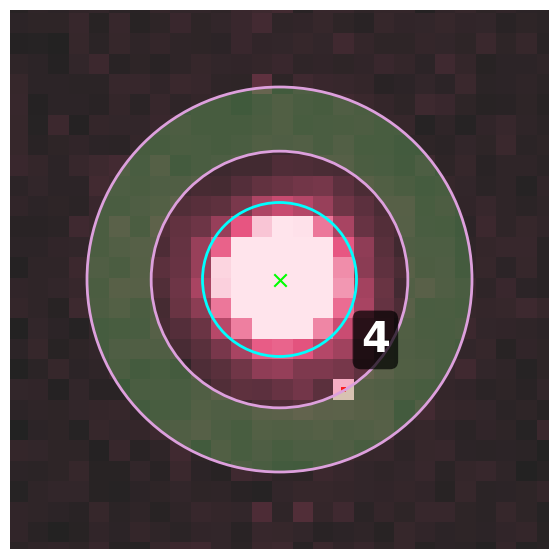

In [16]:
# # --- Draw apertures and annuli on a single frame, ZOOMED IN around target star ---
# from scipy.ndimage import median_filter

# def get_hot_pixel_mask(data, sigma=3):
#     # Only flag a pixel as hot if it is much brighter than ALL its 4-connected neighbors (not a star core)
#     from scipy.ndimage import generic_filter

#     def is_hot_pixel(values):
#         center = values[4]
#         neighbors = np.delete(values, 4)
#         median_neighbors = np.nanmedian(neighbors)
#         std_neighbors = np.std(neighbors)
#         # Hot pixel: much brighter than all neighbors and isolated
#         return (center - median_neighbors) > (sigma * std_neighbors) and np.all(center > neighbors + sigma * std_neighbors)

#     # Apply a 3x3 filter, center pixel compared to its 8 neighbors
#     mask = generic_filter(data, is_hot_pixel, size=3, mode='reflect')
#     return mask.astype(bool)

frame_idx = 1  # Change this to plot a different frame
plt.figure(figsize=(7, 7))
fpath = os.path.join(input_dir, fits_files[frame_idx])
with fits.open(fpath) as hdul:
    data = hdul[0].data.astype(float)
    data -= np.nanmedian(data)
centroids = star_positions[frame_idx]

# Identify hot pixels
# hot_mask = get_hot_pixel_mask(data, sigma=7)

# Show the image
plt.imshow(
    data,
    cmap=custom_cmap,
    origin='lower',
    vmin=np.percentile(data, 5),
    vmax=np.percentile(data, 99)
)

# Overlay hot pixels in red
yy, xx = np.where(hot_mask)
plt.scatter(xx, yy, color='red', s=12, marker='s', label='Hot Pixels', alpha=0.85, edgecolor='none')

from matplotlib.patches import Wedge

if centroids:
    ys, xs = zip(*centroids)
    plt.scatter(xs, ys, color='lime', s=80, marker='x')
    # Draw aperture and annuli for target star only
    x_t, y_t = xs[target_star], ys[target_star]
    circ = Circle((x_t, y_t), aperture_radius, edgecolor='cyan', facecolor='none', lw=2)
    plt.gca().add_patch(circ)
    # Light green see-through highlight for the annulus as a ring
    annulus_ring = Wedge(
        (x_t, y_t),
        r=annulus_r_out,
        theta1=0, theta2=360,
        width=annulus_r_out - annulus_r_in,
        facecolor=(0.5, 1, 0.5, 0.25),  # RGBA for light green, alpha=0.25
        edgecolor='none'
    )
    plt.gca().add_patch(annulus_ring)
    annulus_inner = Circle((x_t, y_t), annulus_r_in, edgecolor='plum', facecolor='none', lw=2, linestyle='-')
    annulus_outer = Circle((x_t, y_t), annulus_r_out, edgecolor='plum', facecolor='none', lw=2, linestyle='-')
    plt.gca().add_patch(annulus_inner)
    plt.gca().add_patch(annulus_outer)
    # Label the target star
    plt.text(
        x_t+4, y_t-4, f"{target_star}",
        color='white',
        fontsize=30,
        ha='left',
        va='bottom',
        weight='bold',
        bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
    )

    # Set zoom window around target star
    zoom_size = annulus_r_out * 1.4  # Show a bit beyond outer annulus
    plt.xlim(x_t - zoom_size, x_t + zoom_size)
    plt.ylim(y_t - zoom_size, y_t + zoom_size)

# plt.title(f"Zoom on Target Star {target_star} with Annulus/Aperture")
plt.axis('off')
plt.show()

Differential light curve standard deviation: 0.018284


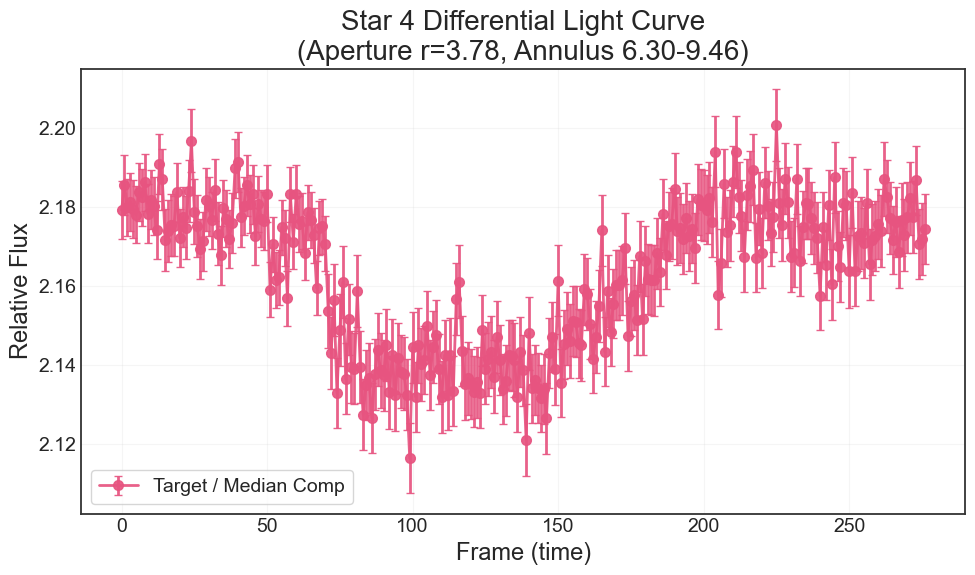

In [17]:
import matplotlib as mpl

# Publication-ready style
plt.style.use('seaborn-v0_8-white')
mpl.rcParams.update({
    "font.size": 15,
    "axes.labelsize": 17,
    "axes.titlesize": 20,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.edgecolor": "0.2",
    "axes.linewidth": 1.3,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "axes.grid": True,
    "grid.alpha": 0.18,
})

comp_brightness = np.array(comp_brightness)
comp_uncertainty = np.array(comp_uncertainty)
mean_comp = np.nanmean(comp_brightness, axis=0)
mean_comp_unc = np.sqrt(np.nansum(comp_uncertainty**2, axis=0)) / np.sum(~np.isnan(comp_uncertainty), axis=0)

target_brightness = np.array(target_brightness)
target_uncertainty = np.array(target_uncertainty)

# Differential light curve: target / mean comparison
diff_lc = target_brightness / mean_comp

# Propagate uncertainties for the ratio
diff_lc_err = diff_lc * np.sqrt(
    (target_uncertainty / target_brightness)**2 +
    (mean_comp_unc / mean_comp)**2
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(
    range(n_frames), diff_lc, yerr=diff_lc_err,
    marker='o', linestyle='-', color="#e75480",
    label='Target / Median Comp', capsize=3, markersize=7, linewidth=2, alpha=0.92
)
ax.set_xlabel("Frame (time)")
ax.set_ylabel("Relative Flux")
ax.set_title(
    f"Star {target_star} Differential Light Curve\n"
    f"(Aperture r={aperture_radius:.2f}, Annulus {annulus_r_in:.2f}-{annulus_r_out:.2f})"
)

# print stdev
std_diff_lc = np.nanstd(diff_lc)
print(f"Differential light curve standard deviation: {std_diff_lc:.6f}")

ax.legend(frameon=True, loc='best')
ax.grid(True, alpha=0.18)
plt.tight_layout()
plt.show()

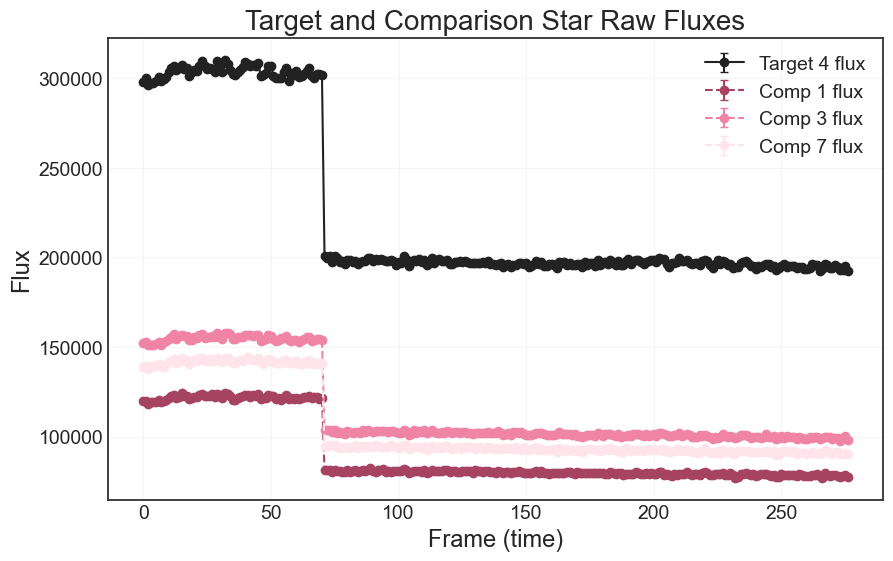

In [18]:
# Calculate mean comparison star brightness for each frame
comp_brightness = np.array(comp_brightness)
comp_uncertainty = np.array(comp_uncertainty)
mean_comp = np.nanmean(comp_brightness, axis=0)
mean_comp_unc = np.sqrt(np.nansum(comp_uncertainty**2, axis=0)) / np.sum(~np.isnan(comp_uncertainty), axis=0)

target_brightness = np.array(target_brightness)
target_uncertainty = np.array(target_uncertainty)

# Differential light curve: target / mean comparison
diff_lc = target_brightness / mean_comp

# Use custom_cmap for color selection
colors = [custom_cmap(i / max(1, len(comp_stars))) for i in range(len(comp_stars) + 1)]

plt.figure(figsize=(10, 6))
plt.errorbar(
    range(n_frames), target_brightness, yerr=target_uncertainty,
    marker='o', color=colors[0], label=f'Target {target_star} flux', capsize=3
)
for j, comp in enumerate(comp_stars):
    plt.errorbar(
        range(n_frames), comp_brightness[j], yerr=comp_uncertainty[j],
        marker='o', linestyle='--', color=colors[j+1], label=f'Comp {comp} flux', capsize=3
    )
plt.xlabel("Frame (time)")
plt.ylabel("Flux")
plt.title(f"Target and Comparison Star Raw Fluxes")
plt.legend()
plt.show()

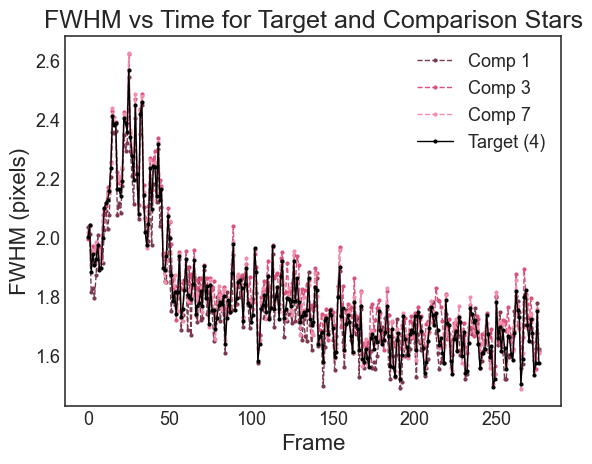

In [27]:
# Initialize a list to store FWHM for each comparison star
fwhm_comps = []

# Comparison stars
for j, comp in enumerate(comp_stars):
    fwhm_comp = []
    for i in range(n_frames):
        if comp >= max_stars or np.isnan(x_positions[comp, i]) or np.isnan(y_positions[comp, i]):
            fwhm_comp.append(np.nan)
            continue
        fpath = os.path.join(input_dir, fits_files[i])
        with fits.open(fpath) as hdul:
            data = hdul[0].data.astype(float)
            data -= np.nanmedian(data)
        y0, x0 = y_positions[comp, i], x_positions[comp, i]
        size = 9
        x1, x2 = int(x0) - size//2, int(x0) + size//2 + 1
        y1, y2 = int(y0) - size//2, int(y0) + size//2 + 1
        if x1 < 0 or y1 < 0 or x2 > data.shape[1] or y2 > data.shape[0]:
            fwhm_comp.append(np.nan)
            continue
        cutout = data[y1:y2, x1:x2]
        y_grid, x_grid = np.mgrid[0:cutout.shape[0], 0:cutout.shape[1]]
        p_init = models.Gaussian2D(amplitude=cutout.max(), x_mean=size//2, y_mean=size//2, x_stddev=2, y_stddev=2)
        fit_p = fitting.LevMarLSQFitter()
        try:
            p = fit_p(p_init, x_grid, y_grid, cutout)
            fwhm = 2.3548 * np.nanmean([p.x_stddev.value, p.y_stddev.value])
            fwhm_comp.append(fwhm)
        except Exception:
            fwhm_comp.append(np.nan)
    
    # Save the FWHM for the current comparison star
    fwhm_comps.append(fwhm_comp)
    plt.plot(range(n_frames), fwhm_comp, marker='o', linestyle='--', color=colors[j+1], label=f'Comp {comp}', markersize=2, linewidth=1)

# Plot the FWHM for the target star
fwhm_target_star = []
for i in range(n_frames):
    fwhm_target_star.append(fwhm_target[i] if i < len(fwhm_target) else np.nan)

plt.plot(range(n_frames), fwhm_target_star, marker='o', linestyle='-', color='k', label='Target (4)', markersize=2, linewidth=1)

plt.xlabel("Frame")
plt.ylabel("FWHM (pixels)")
plt.title(f"FWHM vs Time for Target and Comparison Stars")
plt.legend()


Differential light curve standard deviation: 0.018284


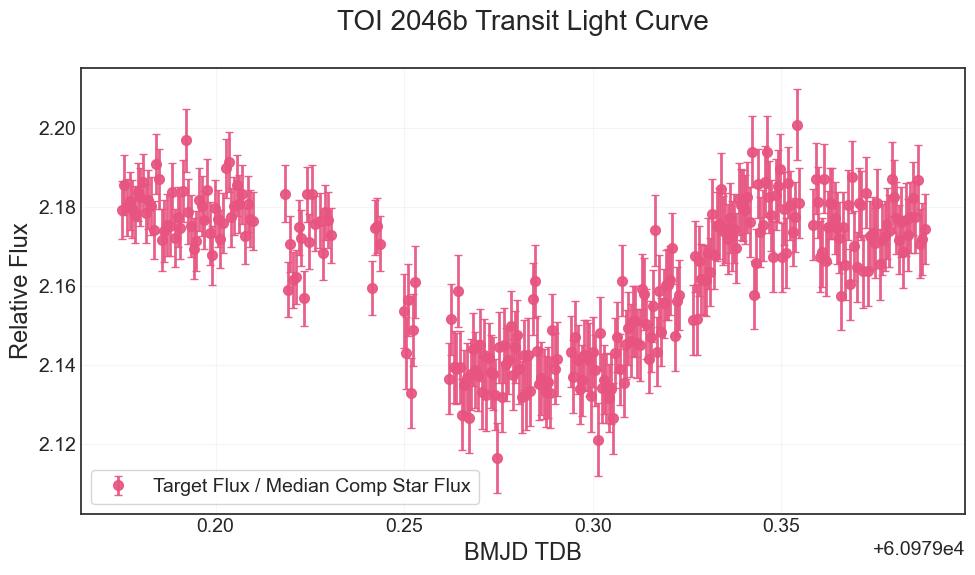

In [47]:
import matplotlib as mpl

# Publication-ready style
plt.style.use('seaborn-v0_8-white')
mpl.rcParams.update({
    "font.size": 15,
    "axes.labelsize": 17,
    "axes.titlesize": 20,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.edgecolor": "0.2",
    "axes.linewidth": 1.3,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "axes.grid": True,
    "grid.alpha": 0.18,
})

comp_brightness = np.array(comp_brightness)
comp_uncertainty = np.array(comp_uncertainty)
mean_comp = np.nanmean(comp_brightness, axis=0)
mean_comp_unc = np.sqrt(np.nansum(comp_uncertainty**2, axis=0)) / np.sum(~np.isnan(comp_uncertainty), axis=0)

target_brightness = np.array(target_brightness)
target_uncertainty = np.array(target_uncertainty)

# Differential light curve: target / mean comparison
diff_lc = target_brightness / mean_comp

# Propagate uncertainties for the ratio
diff_lc_err = diff_lc * np.sqrt(
    (target_uncertainty / target_brightness)**2 +
    (mean_comp_unc / mean_comp)**2
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(
    bmjd_tdb, diff_lc, yerr=diff_lc_err,
    marker='o', linestyle='', color="#e75480",
    label='Target Flux / Median Comp Star Flux', capsize=3, markersize=7, linewidth=2, alpha=0.92
)
ax.set_xlabel("BMJD TDB")
ax.set_ylabel("Relative Flux")
ax.set_title(
    f"TOI 2046b Transit Light Curve\n"
    # f"(Aperture r={aperture_radius:.2f}, Annulus {annulus_r_in:.2f}-{annulus_r_out:.2f})"
)

std_diff_lc = np.nanstd(diff_lc)
print(f"Differential light curve standard deviation: {std_diff_lc:.6f}")

ax.legend(frameon=True, loc='best')
ax.grid(True, alpha=0.18)
plt.tight_layout()
plt.show()

## What I want to ultimately end up with:
 - fwms of target and comp stars (nothing I can do but get from Daphne's notebook)
 - ref1_counts = smt from daphne's notebook
 - ref2...
 - ref3...
 - toi...
 - mjds = ...
 - airmass = ...

# BEGIN ANNIKA NOTEBOOK

In [48]:
ref1_fwhms = fwhm_comps[0]
ref2_fwhms = fwhm_comps[1]
ref3_fwhms = fwhm_comps[2]
toi_fwhms = fwhm_target

ref1_counts = comp_brightness[0]
ref2_counts = comp_brightness[1]
ref3_counts = comp_brightness[2]
toi_counts = target_brightness

mjds = bmjd_tdb

# Final Project Parts 4-7 Analysis

## Imports

In [49]:
from astropy.io import fits
import lmfit
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from scipy.signal import find_peaks, medfilt
from scipy.optimize import curve_fit
import pandas as pd
from matplotlib.colors import LogNorm
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import re
from scipy.ndimage import gaussian_filter1d
from scipy.signal import correlate
from scipy.ndimage import median_filter
from collections import defaultdict

from astropy import units as u
from specutils import Spectrum, SpectralRegion
from specutils.analysis import equivalent_width, fwhm

from scipy.signal import find_peaks, savgol_filter
from scipy.interpolate import interp1d

from scipy.ndimage import center_of_mass, shift
from photutils.centroids import centroid_2dg
from scipy.ndimage import gaussian_filter

from sklearn.linear_model import LinearRegression

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
%matplotlib widget  

## Functions

In [50]:
def collect_fits_files(directory):
    # containers
    rc_files = []
    reduced_files = []
    ref1_files = []
    ref2_files = []
    ref3_files = []
    toi_files = []
    full_files = []

    for fname in os.listdir(directory):
        if not fname.endswith(".fits"):
            continue

        # strip extension
        base = fname[:-5]

        if base.endswith("_rc"):
            rc_files.append(fname)
        elif base.endswith("_reduced"):
            reduced_files.append(fname)
        elif base.endswith("_ref1"):
            ref1_files.append(fname)
        elif base.endswith("_ref2"):
            ref2_files.append(fname)
        elif base.endswith("_ref3"):
            ref3_files.append(fname)
        elif base.endswith("_toi"):
            toi_files.append(fname)
        else:
            # no suffix → full / raw fits
            full_files.append(fname)

    # sort everything for consistency
    for lst in [rc_files, reduced_files, ref1_files, ref2_files, ref3_files, toi_files, full_files]:
        lst.sort()

    return {
        "rc": rc_files,
        "reduced": reduced_files,
        "ref1": ref1_files,
        "ref2": ref2_files,
        "ref3": ref3_files,
        "toi": toi_files,
        "full": full_files,
    }

def identify_target_from_filename(fname, target_centers):
    for key in target_centers:
        if f"_{key}.fits" in fname:
            return key
    return None

def crop_image(data, x0, y0, half_size=20):
    """
    Return an EXACT (2*half_size)x(2*half_size) crop centered on (x0,y0).
    If the crop would go out of bounds, it pads with NaNs so the output is still 40x40.
    """
    ny, nx = data.shape
    size = 2 * half_size

    x0 = int(round(x0))
    y0 = int(round(y0))

    # desired bounds in the original image
    x1 = x0 - half_size
    x2 = x0 + half_size
    y1 = y0 - half_size
    y2 = y0 + half_size

    # overlap with actual image bounds
    ox1 = max(0, x1)
    ox2 = min(nx, x2)
    oy1 = max(0, y1)
    oy2 = min(ny, y2)

    cut = data[oy1:oy2, ox1:ox2]

    # pad into a fixed-size array
    out = np.full((size, size), np.nan, dtype=data.dtype if np.issubdtype(data.dtype, np.floating) else float)

    # where the overlap lands in the output array
    px1 = ox1 - x1
    px2 = px1 + (ox2 - ox1)
    py1 = oy1 - y1
    py2 = py1 + (oy2 - oy1)

    out[py1:py2, px1:px2] = cut
    return out

def recenter_cutout_around_centroid(img, size=20, method="2dg"):
    """
    Find the centroid of a star in a small image and return a new
    size x size cutout centered on that centroid.

    Parameters
    ----------
    img : 2D ndarray
        Input cutout image containing a star.
    size : int
        Output cutout size in pixels (size x size). Prefer even sizes like 20.
    method : {"2dg", "com"}
        Centroiding method:
          - "2dg": photutils centroid_2dg (recommended)
          - "com": center of mass (fallback)

    Returns
    -------
    new_cutout : 2D ndarray
        Recentered cutout (size x size). If near an edge, the function pads with zeros.
    (xc, yc) : tuple of floats
        Centroid coordinates in the original input `img` coordinate system (x, y).
    """
    img = np.asarray(img)
    ny, nx = img.shape

    # Replace NaNs with median for centroiding stability
    if np.any(~np.isfinite(img)):
        med = np.nanmedian(img)
        img_cent = np.where(np.isfinite(img), img, med)
    else:
        img_cent = img

    # --- centroid estimate ---
    if method == "2dg":
        xc, yc = centroid_2dg(img_cent)
    elif method == "com":
        # center-of-mass fallback
        y, x = np.indices(img_cent.shape)
        w = img_cent - np.min(img_cent)
        w = np.clip(w, 0, None)
        tot = np.sum(w)
        if tot == 0:
            xc, yc = (nx - 1) / 2, (ny - 1) / 2
        else:
            xc = np.sum(x * w) / tot
            yc = np.sum(y * w) / tot
    else:
        raise ValueError("method must be '2dg' or 'com'")

    # --- build the new cutout around the centroid ---
    half = size // 2
    x0 = int(np.round(xc))
    y0 = int(np.round(yc))

    x1, x2 = x0 - half, x0 + half
    y1, y2 = y0 - half, y0 + half

    # Create output and paste overlapping region
    new_cutout = np.zeros((size, size), dtype=img.dtype)

    src_x1 = max(0, x1)
    src_x2 = min(nx, x2)
    src_y1 = max(0, y1)
    src_y2 = min(ny, y2)

    dst_x1 = src_x1 - x1
    dst_x2 = dst_x1 + (src_x2 - src_x1)
    dst_y1 = src_y1 - y1
    dst_y2 = dst_y1 + (src_y2 - src_y1)

    new_cutout[dst_y1:dst_y2, dst_x1:dst_x2] = img[src_y1:src_y2, src_x1:src_x2]

    return new_cutout, (xc, yc)

def find_brightest_pixel(data, r=1):
    """
    Find brightest pixel using small circular apertures and return its (x,y) coordinates.
    """
    ny, nx = data.shape

    # Create apertures centered on every pixel
    y, x = np.mgrid[0:ny, 0:nx]
    positions = np.column_stack((x.ravel(), y.ravel()))

    apertures = CircularAperture(positions, r=r)
    phot_table = aperture_photometry(data, apertures)

    # Find brightest aperture
    fluxes = phot_table['aperture_sum']
    idx_max = np.argmax(fluxes)

    x0, y0 = positions[idx_max]
    return int(x0), int(y0)

def gaussian2d(coords, amp, x0, y0, sx, sy, offset):
    x, y = coords
    g = amp * np.exp(-(((x - x0)**2) / (2*sx**2) + ((y - y0)**2) / (2*sy**2))) + offset
    return g.ravel()

def get_fwhm(frame_index, fnames, fit_halfsize=8, sigma_bounds=(0.6, 6.0), smooth_sigma=1.0):
    data = fits.getdata(fnames[frame_index]).astype(float)
    ny, nx = data.shape

    # --- Peak finding on a lightly smoothed image (reduces hot-pixel/cosmic-ray dominance) ---
    data_s = gaussian_filter(data, smooth_sigma)
    y_peak, x_peak = np.unravel_index(np.argmax(data_s), data_s.shape)

    # --- cut a small box around peak ---
    x1 = max(0, x_peak - fit_halfsize)
    x2 = min(nx, x_peak + fit_halfsize + 1)
    y1 = max(0, y_peak - fit_halfsize)
    y2 = min(ny, y_peak + fit_halfsize + 1)

    sub = data[y1:y2, x1:x2]

    # coordinate grids in full-image coordinates
    yy = np.arange(y1, y2)
    xx = np.arange(x1, x2)
    X, Y = np.meshgrid(xx, yy)

    # --- initial guesses ---
    offset0 = np.median(sub)
    sub0 = sub - offset0
    amp0 = np.max(sub0)

    # if there's basically no peak above background, bail
    if amp0 <= 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    x0_0 = x_peak
    y0_0 = y_peak
    sx0 = sy0 = 2.0

    p0 = [amp0, x0_0, y0_0, sx0, sy0, offset0]

    # tighter, physical bounds for sigma
    smin, smax = sigma_bounds
    lower = [0, x1, y1, smin, smin, -np.inf]
    upper = [np.inf, x2-1, y2-1, smax, smax, np.inf]

    try:
        popt, pcov = curve_fit(
            gaussian2d, (X, Y), sub.ravel(),
            p0=p0, bounds=(lower, upper),
            maxfev=20000
        )
    except RuntimeError:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    amp, x0_fit, y0_fit, sx_fit, sy_fit, offset_fit = popt

    # sanity check: reject fits that hug bounds (classic failure mode)
    if (sx_fit >= 0.95*smax) or (sy_fit >= 0.95*smax):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    fwhm_x = 2 * np.sqrt(2 * np.log(2)) * sx_fit
    fwhm_y = 2 * np.sqrt(2 * np.log(2)) * sy_fit

    return x0_fit, y0_fit, sx_fit, sy_fit, fwhm_x, fwhm_y

def calculate_fwhm_stats(fwhm_list):
    fwhm_xs = np.array([fwhm[0] for fwhm in fwhm_list])
    fwhm_ys = np.array([fwhm[1] for fwhm in fwhm_list])

    mean_x = np.mean(fwhm_xs)
    std_x = np.std(fwhm_xs)

    mean_y = np.mean(fwhm_ys)
    std_y = np.std(fwhm_ys)

    mask = (np.abs(fwhm_xs - mean_x) > 1 * std_x) | (np.abs(fwhm_ys - mean_y) > 1 * std_y)

    return mean_x, std_x, mean_y, std_y, mask

def linear_fit(x, y):
    """    
    x is airmass
    y is magnitude
    """
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()

    # Fit with sklearn
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)

    m = model.coef_[0]
    b = model.intercept_

    # Residuals and variance estimate
    yhat = model.predict(x.reshape(-1, 1))
    resid = y - yhat
    n = len(x)
    if n < 3:
        raise ValueError("Need at least 3 points to estimate uncertainties.")
    s2 = np.sum(resid**2) / (n - 2)  # residual variance

    # Sxx and standard errors
    xbar = np.mean(x)
    Sxx = np.sum((x - xbar)**2)
    if Sxx == 0:
        raise ValueError("All x values are identical; cannot fit a slope.")

    sigma_m = np.sqrt(s2 / Sxx)
    sigma_b = np.sqrt(s2 * (1/n + xbar**2 / Sxx))

    return m, b, sigma_m, sigma_b

def extinction_correct_flux(flux, airmass, k_mag_per_airmass, X_ref=None):
    flux = np.asarray(flux, dtype=float)
    X = np.asarray(airmass, dtype=float)

    if X_ref is None:
        dX = X
    else:
        dX = X - float(X_ref)

    return flux * 10.0**(0.4 * k_mag_per_airmass * dX)


## Filepaths

## Part 3) Derive and Check Instrumental Magnitudes

In [51]:
# just assume an ideal aperture size for now and update later
ideal_apertures_size = 3.0 # in pixels 

So it seems like we are expected to just accept the assertion that the ratio between ideal aperture size and source FWHM is constant across all frames. Ideally I would like to verify this assertion by calculating the ideal aperture size at EVERY frame and calculating the ratio of aperture size to FWHM, but that is outside the scope of this project.

In [55]:
ref1_fwhms[6]

np.float64(2.0082703671518476)

In [56]:
# determine ratio of ideal aperture size to mean fwhm_x

# pick a representative frame and get the mean of the fwhms for each target in that frame
index = 6
fwhm_mean = ((ref1_fwhms[index] + ref2_fwhms[index] + ref3_fwhms[index] + toi_fwhms[index]) / 4.0)
ideal_ratio = ideal_apertures_size / fwhm_mean
print(f"Ideal aperture size to mean FWHM ratio: {ideal_ratio:.3f}")

Ideal aperture size to mean FWHM ratio: 1.518


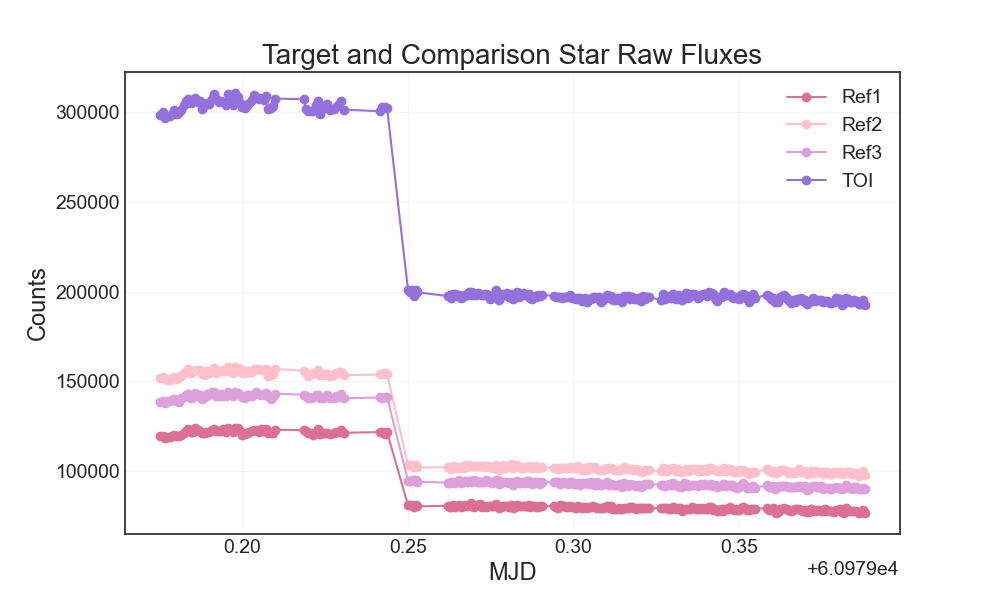

In [58]:
# plot magnitude vs mjd for each target
plt.figure(figsize=(10, 6))
colors = ["palevioletred", "pink", "plum", "mediumpurple"]
names = ["Ref1", "Ref2", "Ref3", "TOI"]
mag_files = [ref1_counts, ref2_counts, ref3_counts, toi_counts]
for i, mags in enumerate(mag_files):
    plt.plot(mjds, mags, marker='o', linestyle='-', color=colors[i], label=f"{names[i]}")
plt.xlabel('MJD')
plt.ylabel('Counts')
plt.title('Target and Comparison Star Raw Fluxes')
plt.legend()
#plt.xlim(mjds[reasonable_xmin], mjds[reasonable_xmax])
#plt.ylim(-14.5, -9)

In [59]:
# for each frame and each target, convert counts to magnitude
def counts_to_mag(counts):
    return -2.5 * np.log10(counts)

ref1_mags = counts_to_mag(np.array(ref1_counts))
ref2_mags = counts_to_mag(np.array(ref2_counts))
ref3_mags = counts_to_mag(np.array(ref3_counts))
toi_mags = counts_to_mag(np.array(toi_counts))

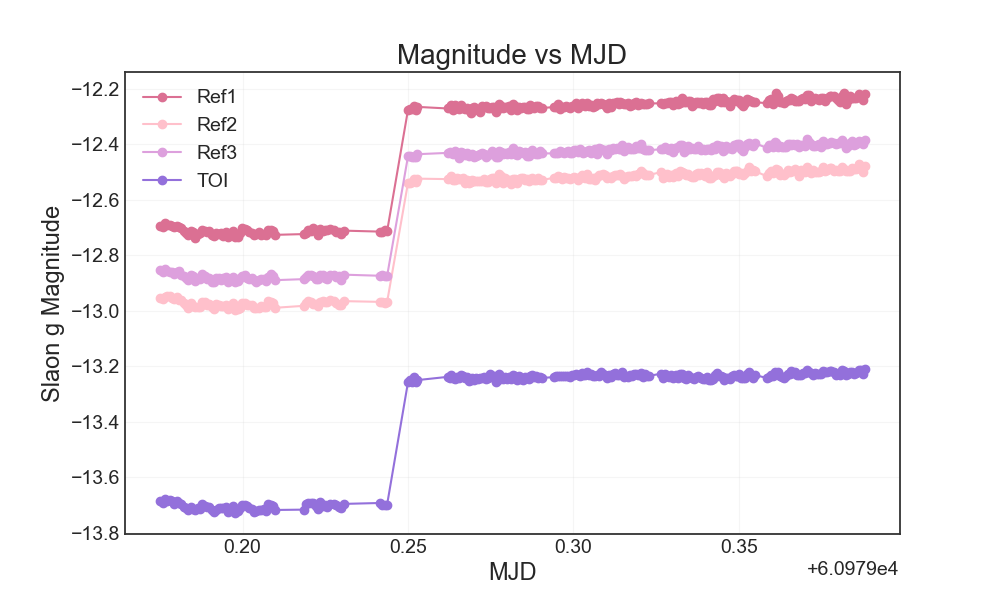

In [61]:
# plot magnitude vs mjd for each target
plt.figure(figsize=(10, 6))
colors = ["palevioletred", "pink", "plum", "mediumpurple"]
names = ["Ref1", "Ref2", "Ref3", "TOI"]
mag_files = [ref1_mags, ref2_mags, ref3_mags, toi_mags]
for i, mags in enumerate(mag_files):
    plt.plot(mjds, mags, marker='o', linestyle='-', color=colors[i], label=f"{names[i]}")
plt.xlabel('MJD')
plt.ylabel('Slaon g Magnitude')
plt.title('Magnitude vs MJD')
plt.legend()

Text(0.5, 1.0, 'Airmass vs MJD')

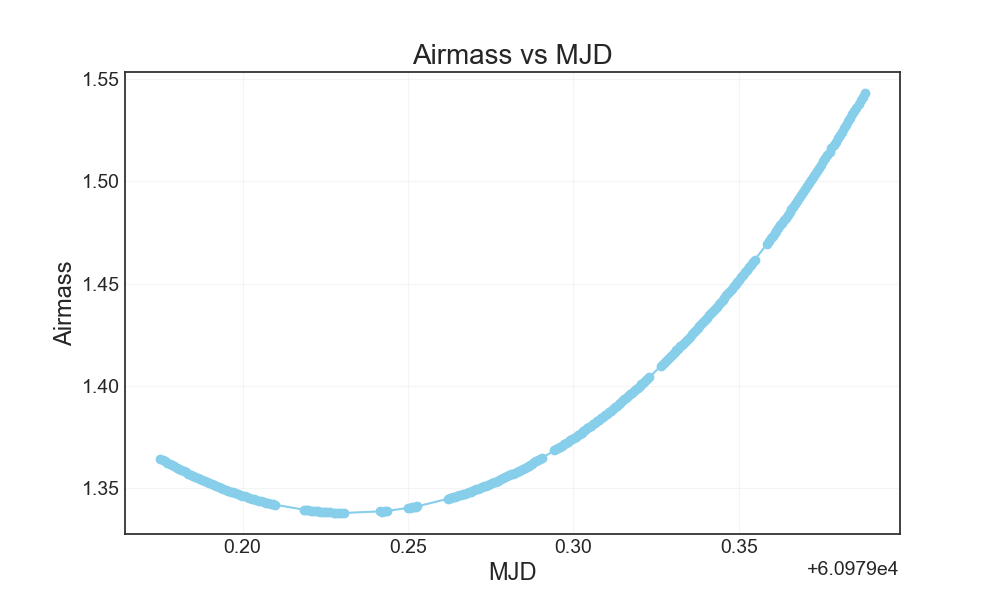

In [64]:
# plot airmass vs mjd
plt.figure(figsize=(10, 6))
plt.plot(mjds, airmass, marker='o', linestyle='-', color='skyblue')
plt.xlabel('MJD')
plt.ylabel('Airmass')
plt.title('Airmass vs MJD')

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

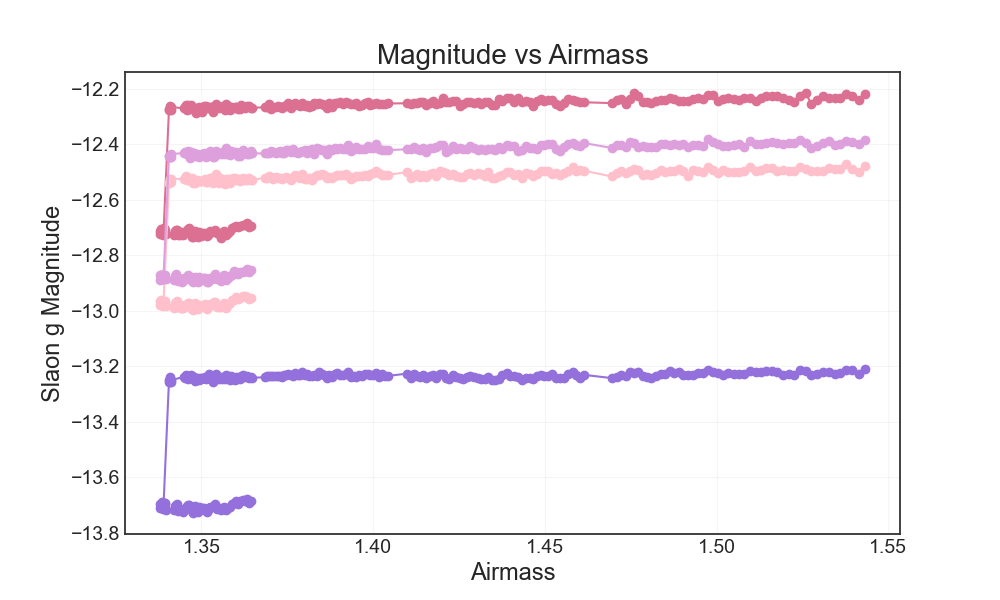

In [67]:
# only plot magnitude versus airmass for each target after it starts to rise
plt.figure(figsize=(10, 6))
colors = ["palevioletred", "pink", "plum", "mediumpurple"]
names = ["Ref1", "Ref2", "Ref3", "TOI"]
mag_files = [ref1_mags, ref2_mags, ref3_mags, toi_mags]
for i, mags in enumerate(mag_files):
    plt.plot(airmass, mags, marker='o', linestyle='-', color=colors[i], label=f"{names[i]}")
plt.xlabel('Airmass')
plt.ylabel('Slaon g Magnitude')
plt.title('Magnitude vs Airmass')
plt.legend

## Part 4) Bouguer's Law
Bouguer's Law states there is a linear relationship between airmass and magnitudes. So, we should fit a linear relationship to the magnitude versus airmass relation shown above:

In [ ]:
# remove any obvious outliers in the magnitude vs airmass data before fitting
def remove_outliers(mags, airmass, sigma=3):
    mags = np.array(mags)
    airmass = np.array(airmass)

    mean_mag = np.mean(mags)
    std_mag = np.std(mags)

    mask = np.abs(mags - mean_mag) < sigma * std_mag

    return mask

mask1 = remove_outliers(ref1_mags, airmass)
mask2 = remove_outliers(ref2_mags, airmass)
mask3 = remove_outliers(ref3_mags, airmass)

airmass_masked = np.array(airmass)[mask1 & mask2 & mask3]
ref1_mags = np.array(ref1_mags)[mask1 & mask2 & mask3]
ref2_mags = np.array(ref2_mags)[mask1 & mask2 & mask3]
ref3_mags = np.array(ref3_mags)[mask1 & mask2 & mask3]
toi_mags = np.array(toi_mags)[mask1 & mask2 & mask3]
mjds = np.array(mjds)[mask1 & mask2 & mask3]

# remove those outliers in the counts as well
ref1_counts = np.array(ref1_counts)[mask1 & mask2 & mask3]
ref2_counts = np.array(ref2_counts)[mask1 & mask2 & mask3]
ref3_counts = np.array(ref3_counts)[mask1 & mask2 & mask3]
toi_counts = np.array(toi_counts)[mask1 & mask2 & mask3]

In [70]:
# conditions for bouguer's law fitting
# 1) airmass rising only

# 2) after magnitude jump at ~ 60979.25 (entails condition 1, so just use this actually)
cutoff_mjd = 60979.25
idx = np.argmin(np.abs(mjds - cutoff_mjd))

mask = np.ones(len(airmass), dtype=bool)
mask[:idx] = False

airmass_bouguer_1 = np.array(airmass)[mask]
ref1_mags_bouguer = np.array(ref1_mags)[mask]

airmass_bouguer_2 = np.array(airmass)[mask]
ref2_mags_bouguer = np.array(ref2_mags)[mask]

airmass_bouguer_3 = np.array(airmass)[mask]
ref3_mags_bouguer = np.array(ref3_mags)[mask]

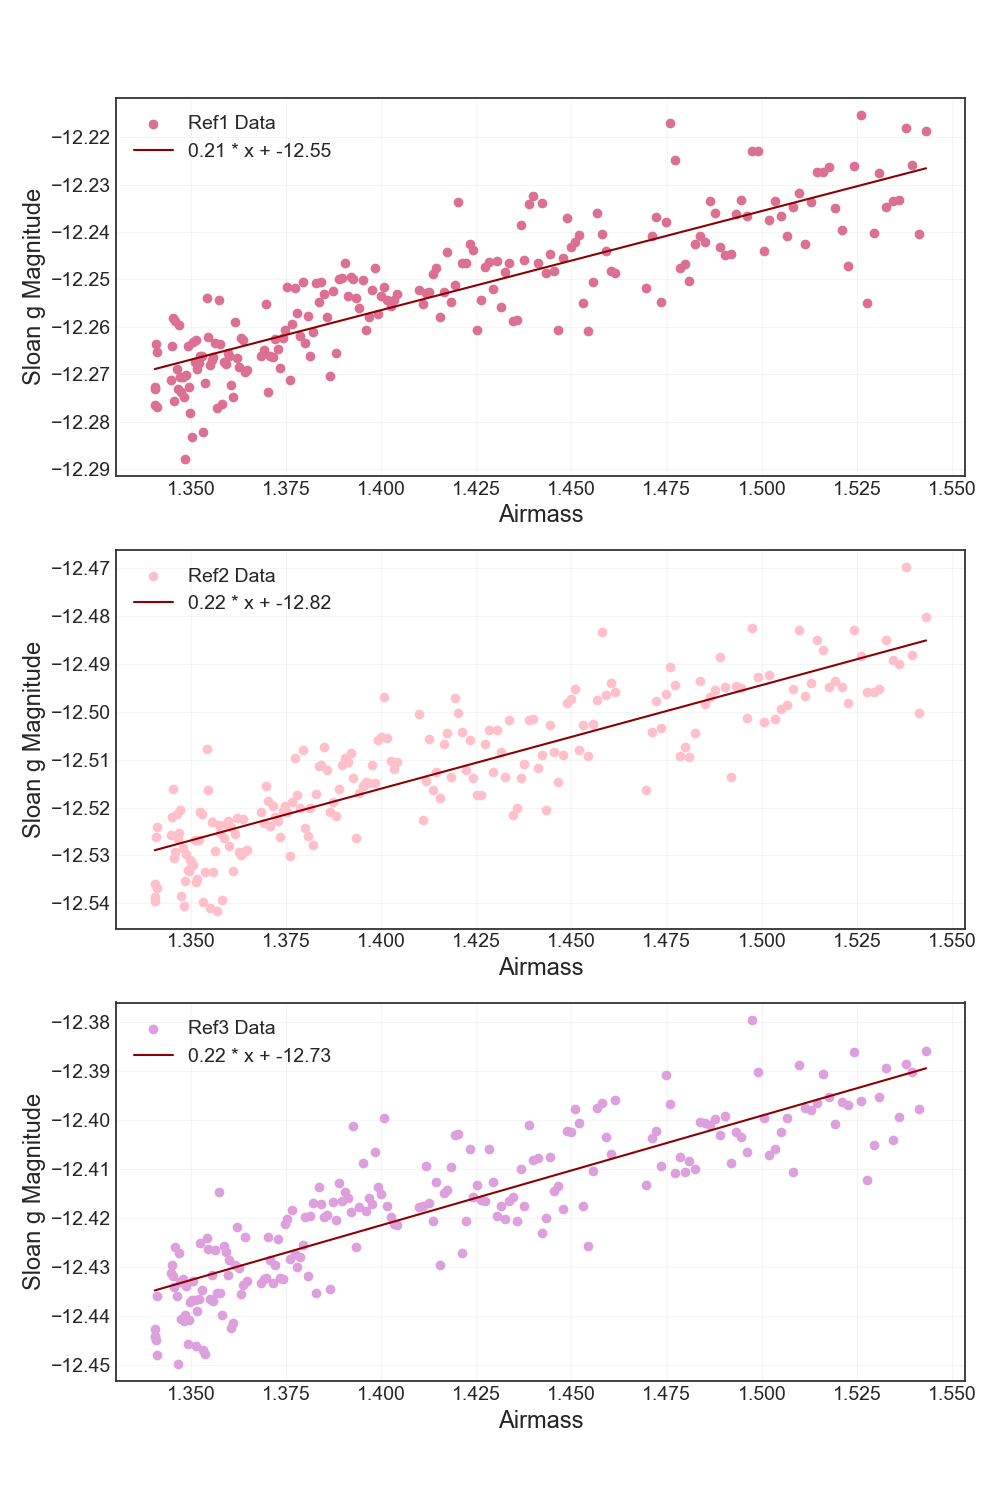

In [71]:
# apply linear regression to magnitude vs airmass for each ref star and plot the results

# Prepare the figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Get linear fit parameters for each reference star
slope_ref1, intercept_ref1, dm1, db1 = linear_fit(airmass_bouguer_1, ref1_mags_bouguer)
slope_ref2, intercept_ref2, dm2, db2 = linear_fit(airmass_bouguer_2, ref2_mags_bouguer)
slope_ref3, intercept_ref3, dm3, db3 = linear_fit(airmass_bouguer_3, ref3_mags_bouguer)

# plot each stars data with its linear fit
axs[0].scatter(airmass_bouguer_1, ref1_mags_bouguer, color='palevioletred', label='Ref1 Data')
axs[0].plot(airmass_bouguer_1, slope_ref1 * airmass_bouguer_1 + intercept_ref1, color='darkred', 
            label=f'{slope_ref1:.2f} * x + {intercept_ref1:.2f}')
axs[0].set_xlabel('Airmass')
axs[0].set_ylabel('Sloan g Magnitude')

axs[1].scatter(airmass_bouguer_2, ref2_mags_bouguer, color='pink', label='Ref2 Data')
axs[1].plot(airmass_bouguer_2, slope_ref2 * airmass_bouguer_2 + intercept_ref2, color='darkred',
            label=f'{slope_ref2:.2f} * x + {intercept_ref2:.2f}')
axs[1].set_xlabel('Airmass')
axs[1].set_ylabel('Sloan g Magnitude')

axs[2].scatter(airmass_bouguer_3, ref3_mags_bouguer, color='plum', label='Ref3 Data')
axs[2].plot(airmass_bouguer_3, slope_ref3 * airmass_bouguer_3 + intercept_ref3, color='darkred',
            label=f'{slope_ref3:.2f} * x + {intercept_ref3:.2f}')
axs[2].set_xlabel('Airmass')
axs[2].set_ylabel('Sloan g Magnitude')

for i in range(3):
    axs[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [72]:
# print the atmospheric extinction coefficient for each target
print("Reference Stars Atmospheric Extinction Coefficients:")
print(f"    1) {slope_ref1:.3f} +/- {dm1:.3f} mag/airmass")
print(f"    2) {slope_ref2:.3f} +/- {dm2:.3f} mag/airmass")
print(f"    3) {slope_ref3:.3f} +/- {dm3:.3f} mag/airmass")

# average the extinction coefficients
k_avg = (slope_ref1 + slope_ref2 + slope_ref3) / 3.0
dk_avg = np.sqrt(dm1**2 + dm2**2 + dm3**2) / 3.0
print(f"Average extinction coefficient: {k_avg:.3f} +/- {dk_avg:.3f} mag/airmass")

Reference Stars Atmospheric Extinction Coefficients:
    1) 0.209 +/- 0.009 mag/airmass
    2) 0.216 +/- 0.008 mag/airmass
    3) 0.223 +/- 0.009 mag/airmass
Average extinction coefficient: 0.216 +/- 0.005 mag/airmass


These values agree nicely with those expected for the sloan g filter, which hovers around 0.18-0.22 mag/airmass.

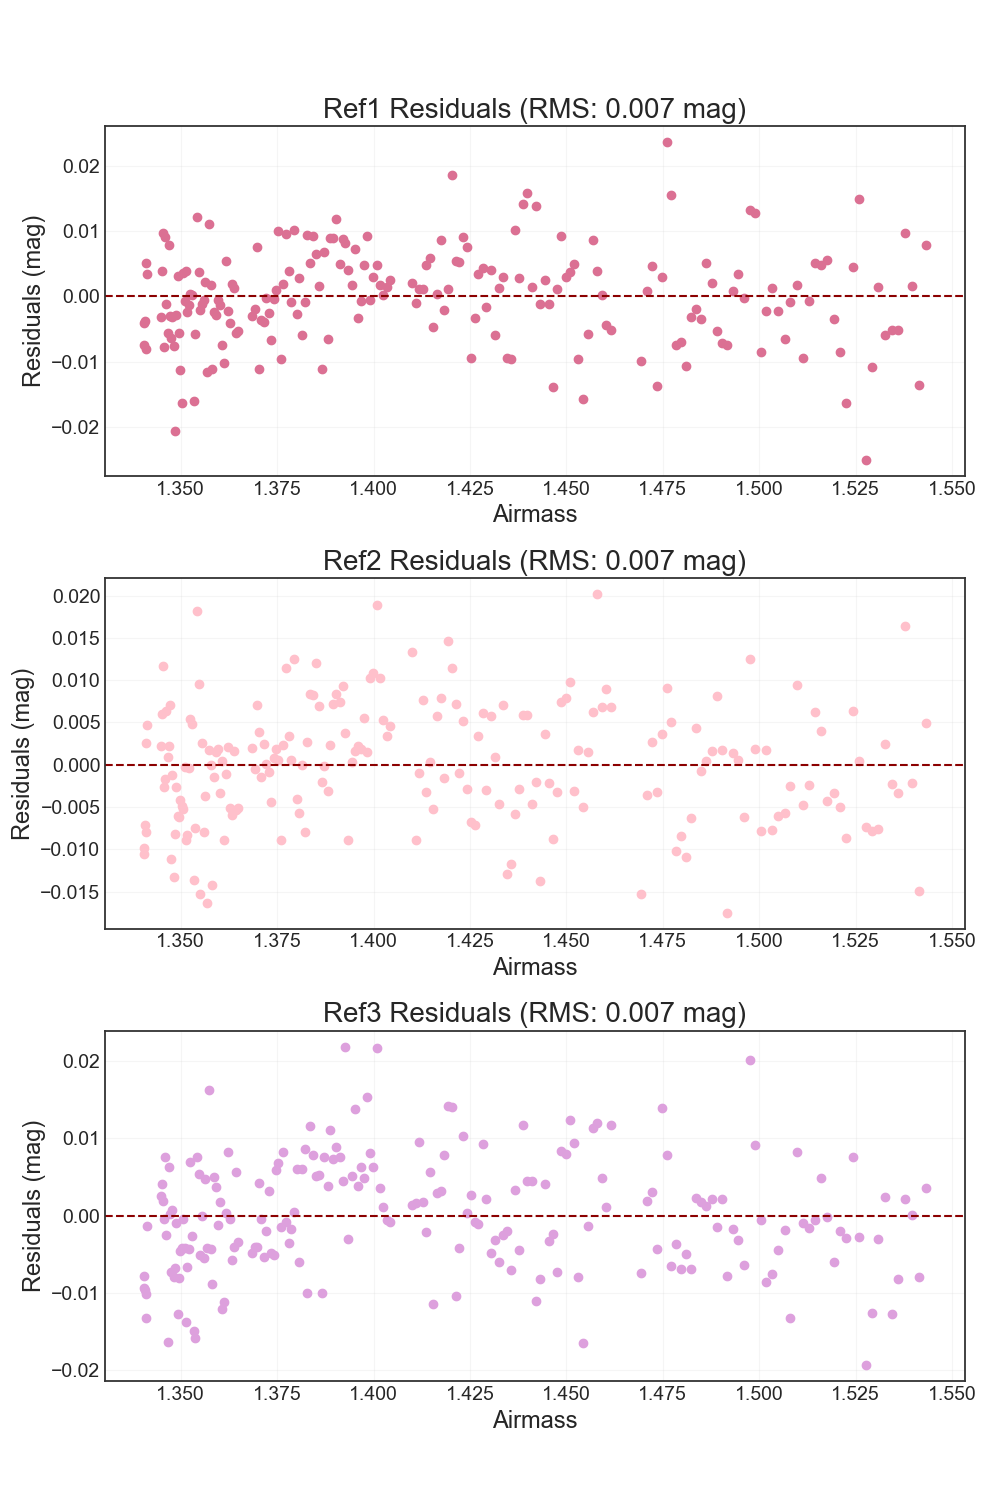

In [73]:
# calculate the RMS of the residuals for each ref star, and plot the residuals 
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Ref1 residuals
yhat_ref1 = slope_ref1 * airmass_bouguer_1 + intercept_ref1
resid_ref1 = ref1_mags_bouguer - yhat_ref1
rms_ref1 = np.sqrt(np.mean(resid_ref1**2))
axs[0].scatter(airmass_bouguer_1, resid_ref1, color='palevioletred')
axs[0].axhline(0, color='darkred', linestyle='--')
axs[0].set_xlabel('Airmass')
axs[0].set_ylabel('Residuals (mag)')
axs[0].set_title(f'Ref1 Residuals (RMS: {rms_ref1:.3f} mag)')

# Ref2 residuals
yhat_ref2 = slope_ref2 * airmass_bouguer_2 + intercept_ref2
resid_ref2 = ref2_mags_bouguer - yhat_ref2
rms_ref2 = np.sqrt(np.mean(resid_ref2**2))
axs[1].scatter(airmass_bouguer_2, resid_ref2, color='pink')
axs[1].axhline(0, color='darkred', linestyle='--')
axs[1].set_xlabel('Airmass')
axs[1].set_ylabel('Residuals (mag)')
axs[1].set_title(f'Ref2 Residuals (RMS: {rms_ref2:.3f} mag)')

# Ref3 residuals
yhat_ref3 = slope_ref3 * airmass_bouguer_3 + intercept_ref3
resid_ref3 = ref3_mags_bouguer - yhat_ref3
rms_ref3 = np.sqrt(np.mean(resid_ref3**2))
axs[2].scatter(airmass_bouguer_3, resid_ref3, color='plum')
axs[2].axhline(0, color='darkred', linestyle='--')
axs[2].set_xlabel('Airmass')
axs[2].set_ylabel('Residuals (mag)')
axs[2].set_title(f'Ref3 Residuals (RMS: {rms_ref3:.3f} mag)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Part 5) Relative Photometry and Transit

In [75]:
# get correction term by median-combining the ref star fluxes
refs = np.vstack([ref1_counts, ref2_counts, ref3_counts])
refs_norm = refs / np.median(refs, axis=1, keepdims=True)
ref_ensemble = np.median(refs_norm, axis=0)

In [88]:
# divide airmass corrected toi flux by correction term to get final light curve
toi_final_flux = toi_counts / ref_ensemble
toi_final_flux = toi_final_flux / np.median(toi_final_flux) # normalize

# Propagate uncertainties for the ratio
toi_final_uncertainty = toi_final_flux * np.sqrt(
    (target_uncertainty / target_brightness)**2 +
    (mean_comp_unc / mean_comp)**2
)

Text(0.5, 1.0, 'Normalized Light Curve for TOI-2046b')

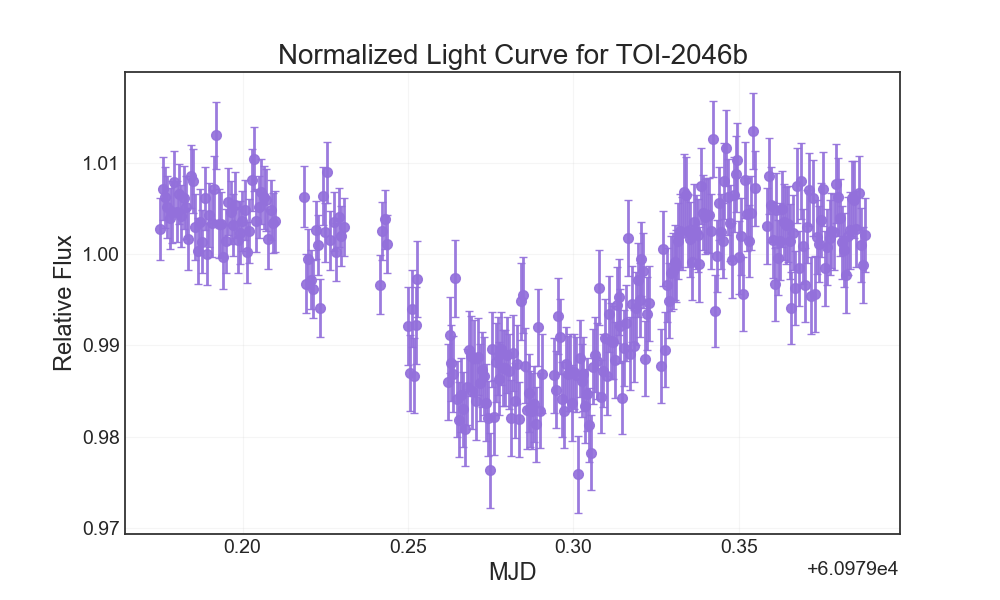

In [89]:
# plot relative flux vs mjd for toi target
outlier_mask = ((toi_final_flux > 0.8) & (toi_final_flux < 1.12))
ones = np.ones_like(toi_final_flux)

plt.figure(figsize=(10, 6))
plt.errorbar(
    mjds, toi_final_flux,
    yerr=toi_final_uncertainty,
    marker='o', linestyle='', color='mediumpurple',
    capsize=3, markersize=7, linewidth=2, alpha=0.92
)
#plt.scatter(mjds, toi_final_flux, marker='o', color='mediumpurple')
plt.xlabel('MJD')
plt.ylabel('Relative Flux')
plt.title('Normalized Light Curve for TOI-2046b')


## Part 6) Derive the Transit Timing

In [91]:
# imports
import matplotlib.pyplot as plt
import os
from pathlib import Path
from astropy.io import fits
from datetime import datetime
import h5py
import numpy as np
from astropy import units as u
import emcee
import batman
import corner

In [92]:
# all we care about now are fluxes, errors, and times, so define those here
times_clean = bmjd_tdb
data_clean = toi_final_flux / np.nanmedian(toi_final_flux)
derr_clean = toi_final_uncertainty

obj_name = "TOI-2046b"

In [93]:
# initial guesses for the parameters

periodIn    = 1.4971842
tcenterIn   = bmjd_tdb[len(bmjd_tdb)//2]  # example: midpoint of observation
incIn       = 80 # inclination
aprsIn      = 4.75 # semi major axis / stellar radius
rprsIn      = 0.25 # planet radius / stellar radius
eccIn       = 0.0 # eccentricity
omegaIn     = 90.0 # phase of eclipse I think (doesn't really matter for this)
u1In        = 0.0 # limb darkening params
u2In        = 0.0
offset      = 1.0 # out-of-transit flux level

# things I don't use but could be added
# slope       = 0.0 # slope of out-of-transit flux
# curvature   = 0.0 # curvature of out-of-transit flux

In [94]:
# functions
def get_param_names(ldtype):
    # Return parameter names for each limb darkening law
    if ldtype == 'uniform':
        return ['tcenter', 'inc', 'rprs', 'offset']
    elif ldtype == 'linear':
        return ['tcenter', 'inc', 'rprs', 'u1', 'offset']
    else:
        # quadratic, logarithmic, etc.
        return ['tcenter', 'inc', 'rprs', 'u1', 'u2', 'offset']

def batman_wrapper_mcmc(theta, times, ldtype='', transitType='primary'):
    names = get_param_names(ldtype)
    # Unpack parameters according to ldtype
    tcenter = theta[0]
    inc = theta[1]
    rprs = theta[2]
    if ldtype == 'uniform':
        offset = theta[3]
        u1, u2 = 0.0, 0.0
    elif ldtype == 'linear':
        u1 = theta[3]
        offset = theta[4]
        u2 = 0.0
    else:
        u1 = theta[3]
        u2 = theta[4]
        offset = theta[5]

    bm_params = batman.TransitParams()
    bm_params.per = periodIn
    bm_params.t0 = tcenter
    bm_params.inc = inc
    bm_params.a = aprsIn
    bm_params.rp = rprs
    bm_params.ecc = eccIn
    bm_params.w = omegaIn
    bm_params.limb_dark = ldtype
    if ldtype == 'linear':
        bm_params.u = [u1]
    elif ldtype in ['quadratic', 'logarithmic', 'exponential', 'squareroot', 'power2']:
        bm_params.u = [u1, u2]
    elif ldtype == 'uniform':
        bm_params.u = []

    out_of_transit = offset
    m_eclipse = batman.TransitModel(bm_params, times, transittype=transitType)
    return m_eclipse.light_curve(bm_params) * out_of_transit

def log_prior(theta, ldtype):
    names = get_param_names(ldtype)
    # Unpack parameters
    tcenter = theta[0]
    inc = theta[1]
    rprs = theta[2]
    if ldtype == 'uniform':
        offset = theta[3]
        u1, u2 = 0.0, 0.0
    elif ldtype == 'linear':
        u1 = theta[3]
        offset = theta[4]
        u2 = 0.0
    else:
        u1 = theta[3]
        u2 = theta[4]
        offset = theta[5]

    if not (bmjd_tdb[0] < tcenter < bmjd_tdb[-1]): return -np.inf
    if not (75 < inc < 90): return -np.inf
    if not (0.01 < rprs < 0.25): return -np.inf
    if not (2 < aprsIn < 10): return -np.inf

    if ldtype == 'uniform':
        if not (0.9 < offset < 1.1): return -np.inf
    elif ldtype == 'linear':
        if not (-1 < u1 < 1): return -np.inf
        if not (0.9 < offset < 1.1): return -np.inf
    elif ldtype == 'quadratic':
        if not (-1 < u1 < 2.0): return -np.inf
        if not (-1 < u2 < 2.0): return -np.inf
        if not (0.9 < offset < 1.1): return -np.inf
    elif ldtype == 'logarithmic':
        if not (0.2 < u1 < 0.8): return -np.inf
        if not (0.2 < u2 < 0.8): return -np.inf
        if not (0.9 < offset < 1.1): return -np.inf
    elif ldtype == 'exponential':
        if not (0.01 < u1 < 1.0): return -np.inf
        if not (0.01 < u2 < 1.0): return -np.inf
        if not (0.9 < offset < 1.1): return -np.inf
    elif ldtype == 'squareroot':
        if not (0.01 < u1 < 2): return -np.inf
        if not (0.01 < u2 < 2): return -np.inf
        if not (0.9 < offset < 1.1): return -np.inf
    elif ldtype == 'power2':
        if not (0.01 < u1 < 1): return -np.inf
        if not (0.01 < u2 < 1): return -np.inf
        if not (0.9 < offset < 1.1): return -np.inf
    else:
        if not (-1 < u1 < 2): return -np.inf
        if not (-1 < u2 < 2): return -np.inf
        if not (0.9 < offset < 1.1): return -np.inf
    return 0.0

def log_likelihood(theta, times, data, derr, ldtype):
    model = batman_wrapper_mcmc(theta, times, ldtype=ldtype)
    return -0.5 * np.sum(((data - model) / derr) ** 2)

def log_probability(theta, times, data, derr, ldtype):
    lp = log_prior(theta, ldtype)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, times, data, derr, ldtype)


In [95]:
# set up mcmc
ldtypes = [
    'uniform',
    # 'linear',
    # 'quadratic',
    # 'logarithmic',
    # 'exponential',
    # 'squareroot',
    # 'power2'
]
results = []

for ldtype in ldtypes:
    print(f"Running MCMC for limb darkening: {ldtype}")
    param_names = get_param_names(ldtype)
    # Set initial guess vector for each law
    if ldtype == 'uniform':
        initial = [tcenterIn, incIn, rprsIn, offset]
    elif ldtype == 'linear':
        initial = [tcenterIn, incIn, rprsIn, u1In, offset]
    else:
        initial = [tcenterIn, incIn, rprsIn, u1In, u2In, offset]

    ndim = len(initial)
    nwalkers = 2000
    pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(times_clean, data_clean, derr_clean, ldtype))
    sampler.run_mcmc(pos, 10000, progress=True)
    samples = sampler.get_chain(discard=2000, flat=True)
    best_fit = np.nanmedian(samples, axis=0)
    loglike = log_likelihood(best_fit, times_clean, data_clean, derr_clean, ldtype)
    n_params = len(best_fit)
    n_data = len(times_clean)
    BIC = n_params * np.log(n_data) - 2 * loglike
    results.append({'ldtype': ldtype, 'samples': samples, 'best_fit': best_fit, 'loglike': loglike, 'BIC': BIC, 'param_names': param_names})


Running MCMC for limb darkening: uniform


You must install the tqdm library to use progress indicators with emcee
/opt/anaconda3/envs/observational/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


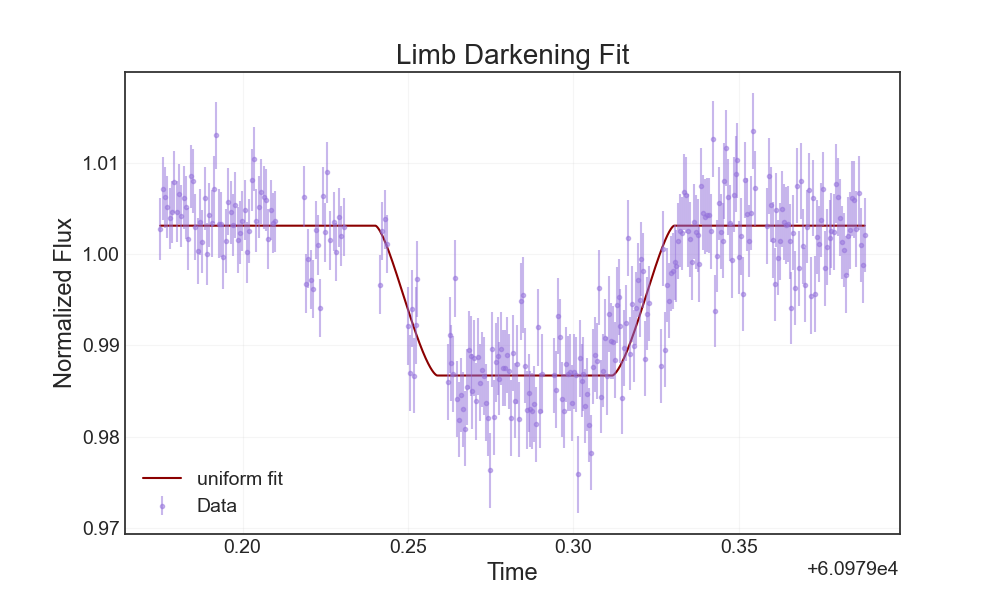

Limb Darkening Type: uniform
  Log-likelihood: -144.07
  Chi-squared: 288.13
  Reduced chi-squared: 1.055
  Degrees of freedom: 273
  BIC: 310.6
  tcenter: 60979.28530336 (+0.00120533/-0.00119438)
  rprs: 81.53105080 (+0.35006513/-0.31433360)
  u1: 0.12791285 (+0.00222533/-0.00225240)
  offset: 1.00312210 (+0.00030724/-0.00030601)

Model Comparison Summary:
Best log-likelihood: uniform
Best chi-squared: uniform


In [105]:
plt.figure(figsize=(10, 6))

# Fine time grid for smooth model curve
t_fine = np.linspace(times_clean.min(), times_clean.max(), 2000)

for result in results:
    ldtype = result['ldtype']
    best_fit = result['best_fit']
    model_fine = batman_wrapper_mcmc(best_fit, t_fine, ldtype=ldtype)
    plt.plot(t_fine, model_fine, label=f'{ldtype} fit', color='darkred')
    # plt.xlim(t0_published_prop_to_epoch - 0.005, t0_published_prop_to_epoch + 0.005)

plt.errorbar(times_clean, data_clean, yerr=derr_clean, fmt='.', color='mediumpurple', alpha=0.5, label='Data')
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.title('Limb Darkening Fit')
plt.legend()
plt.show()

# print stats summary for each limb darkening coeff:
for result in results:
    ldtype = result['ldtype']
    samples = result['samples']
    best_fit = result['best_fit']
    loglike = result['loglike']
    
    # Calculate chi-squared statistics
    model_fit = batman_wrapper_mcmc(best_fit, times_clean, ldtype=ldtype)
    residuals = data_clean - model_fit
    chi2 = np.sum((residuals / derr_clean) ** 2)
    ndof = len(times_clean) - len(best_fit)
    reduced_chi2 = chi2 / ndof
    
    # Calculate BIC for model comparison
    n_params = len(best_fit)
    n_data = len(times_clean)
    BIC = n_params * np.log(n_data) - 2 * loglike
    
    print(f"Limb Darkening Type: {ldtype}")
    print(f"  Log-likelihood: {loglike:.2f}")
    print(f"  Chi-squared: {chi2:.2f}")
    print(f"  Reduced chi-squared: {reduced_chi2:.3f}")
    print(f"  Degrees of freedom: {ndof}")
    print(f"  BIC: {BIC:.1f}")
    
    param_names = ['tcenter', 'rprs', 'u1', 'offset']  # Updated for your 5-parameter model
    for i, name in enumerate(param_names):
        param_samples = samples[:, i]
        median = np.nanmedian(param_samples)
        lower = np.percentile(param_samples, 16)
        upper = np.percentile(param_samples, 84)
        print(f"  {name}: {median:.8f} (+{upper - median:.8f}/-{median - lower:.8f})")
    print()

# Find best model based on different criteria
best_loglike = max(results, key=lambda x: x['loglike'])
best_chi2 = min(results, key=lambda x: np.sum((data_clean - batman_wrapper_mcmc(x['best_fit'], times_clean, ldtype=x['ldtype'])) ** 2 / derr_clean ** 2))

print("Model Comparison Summary:")
print(f"Best log-likelihood: {best_loglike['ldtype']}")
print(f"Best chi-squared: {best_chi2['ldtype']}")

Bisected-chord mid-time: 60979.2853034494
  ingress half-depth crossing: 60979.2502357190
  egress  half-depth crossing: 60979.3203711798


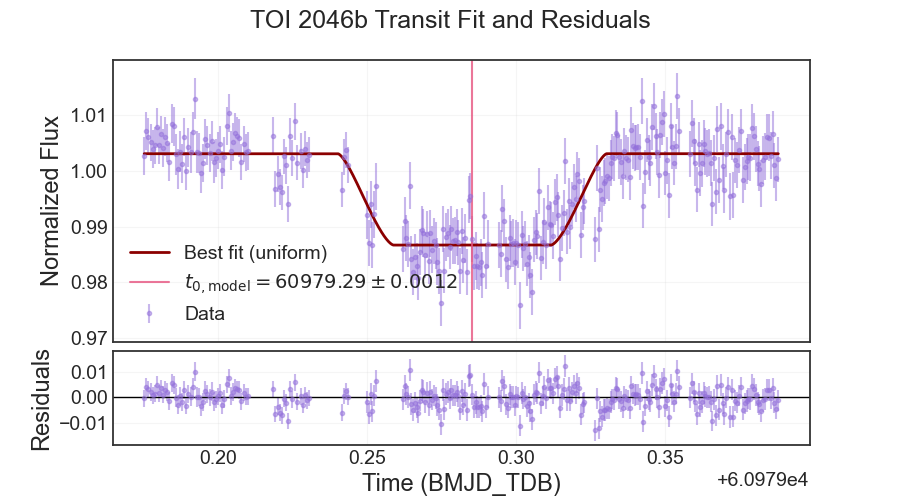

In [112]:
import numpy as np
import matplotlib.pyplot as plt

def bisected_chord_midtime(times, flux, t0_guess=None, window=None,
                           smooth=False, smooth_win=5):
    """
    Bisected-chord mid-time estimator.

    Parameters
    ----------
    times : array
        Time array.
    flux : array
        Normalized flux array (continuum ~1).
    t0_guess : float, optional
        Approximate mid-time to restrict to a local window (recommended).
    window : float, optional
        Half-width of time window around t0_guess to search (same units as times).
    smooth : bool
        If True, apply a simple running median to flux before threshold finding.
    smooth_win : int
        Window size for running median (odd preferred).

    Returns
    -------
    t_mid : float
        Bisected chord mid-time.
    t_ing : float
        Ingress half-depth crossing time.
    t_egr : float
        Egress half-depth crossing time.
    level : float
        Half-depth flux level used.
    """
    times = np.asarray(times)
    flux = np.asarray(flux)

    # Restrict to a window around guess (helps avoid false crossings)
    if (t0_guess is not None) and (window is not None):
        m = (times >= t0_guess - window) & (times <= t0_guess + window)
        times = times[m]
        flux = flux[m]

    # Optional smoothing to reduce noise near crossings
    if smooth:
        from scipy.signal import medfilt
        if smooth_win % 2 == 0:
            smooth_win += 1
        flux_use = medfilt(flux, kernel_size=smooth_win)
    else:
        flux_use = flux

    # Estimate out-of-transit and in-transit levels robustly
    # (use top/bottom quantiles to avoid outliers)
    oot = np.nanmedian(flux_use[flux_use >= np.nanpercentile(flux_use, 70)])
    it  = np.nanmedian(flux_use[flux_use <= np.nanpercentile(flux_use, 30)])

    depth = oot - it
    level = oot - 0.5 * depth   # half-depth level

    # Find indices where curve crosses the level
    # We look for sign changes in (flux - level)
    y = flux_use - level
    s = np.sign(y)
    s[np.isnan(s)] = 0

    crossings = np.where(s[:-1] * s[1:] < 0)[0]  # sign change between i and i+1

    if len(crossings) < 2:
        raise RuntimeError("Could not find two half-depth crossings. "
                           "Try providing t0_guess+window or smoothing.")

    # If there are many crossings (noise), pick the two that bracket the minimum flux
    imin = np.nanargmin(flux_use)
    # crossings left of min and right of min
    left = crossings[crossings < imin]
    right = crossings[crossings > imin]
    if (len(left) == 0) or (len(right) == 0):
        # fallback: take first and last
        i1, i2 = crossings[0], crossings[-1]
    else:
        i1, i2 = left[-1], right[0]

    # Linear interpolation for crossing times
    def interp_cross(i):
        t1, t2 = times[i], times[i+1]
        f1, f2 = flux_use[i], flux_use[i+1]
        # solve f(t)=level linearly
        return t1 + (level - f1) * (t2 - t1) / (f2 - f1)

    t_ing = interp_cross(i1)
    t_egr = interp_cross(i2)
    t_mid = 0.5 * (t_ing + t_egr)

    return t_mid, t_ing, t_egr, level


# -----------------------
# Choose your best model (here: best loglike)
best = best_loglike
ldtype_best = best['ldtype']
theta_best = best['best_fit']

# Evaluate model on observed times
model_best = batman_wrapper_mcmc(theta_best, times_clean, ldtype=ldtype_best)
resid = data_clean - model_best

# Bisected chord on model
t0_guess = theta_best[0]  # tcenter from your fit
try:
    t_mid, t_ing, t_egr, half_level = bisected_chord_midtime(
        times_clean, model_best,
        t0_guess=t0_guess, window=0.05,  # good starting point
        smooth=False
    )
except RuntimeError:
    # fallback: do it on data with smoothing
    t_mid, t_ing, t_egr, half_level = bisected_chord_midtime(
        times_clean, data_clean,
        t0_guess=t0_guess, window=0.05,
        smooth=True, smooth_win=7
    )

print(f"Bisected-chord mid-time: {t_mid:.10f}")
print(f"  ingress half-depth crossing: {t_ing:.10f}")
print(f"  egress  half-depth crossing: {t_egr:.10f}")

# -----------------------
# Plot data + best-fit + residuals
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(9, 5), sharex=True,
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

# Smooth curve for plotting
t_fine = np.linspace(times_clean.min(), times_clean.max(), 4000)
model_fine = batman_wrapper_mcmc(theta_best, t_fine, ldtype=ldtype_best)

ax1.errorbar(times_clean, data_clean, yerr=derr_clean, fmt='.', alpha=0.5, label='Data', color='mediumpurple')
ax1.plot(t_fine, model_fine, lw=2, label=f'Best fit ({ldtype_best})', color='darkred')

# get value and uncertainty of mid-time
tcenter_idx = best['param_names'].index('tcenter')
tcenter_median = theta_best[tcenter_idx]
tcenter_samples = best['samples'][:, tcenter_idx]
tcenter_lower = np.percentile(tcenter_samples, 16)
tcenter_upper = np.percentile(tcenter_samples, 84)
tcenter_uncertainty = 0.5 * (tcenter_upper - tcenter_lower)


# Mark bisected-chord features
ax1.axvline(t_mid, color="#e75480", ls='-', alpha=0.8, label = fr"$t_{{0,\mathrm{{model}}}} = {tcenter_median:.2f} \pm {tcenter_uncertainty:.4f}$")

ax1.set_ylabel("Normalized Flux")
ax1.legend(loc='best')

ax2.errorbar(times_clean, resid, yerr=derr_clean, fmt='.', alpha=0.5, color='mediumpurple')
ax2.axhline(0, color='k', lw=1)
ax2.set_xlabel("Time (BMJD_TDB)")
ax2.set_ylabel("Residuals")

fig.suptitle("TOI 2046b Transit Fit and Residuals")

plt.show()

## Part 7) Compare with published results

instrumental magnitudes: just convert the raw flux to a magnitude. m = -2.5log_10(raw flux)

when making the light curves, when normalizing by the fluxes of the reference stars, normalize by the MEDIAN of the fluxes of the reference stars, to mitigate any outliers in flux. 